# MSBD 5013 - Statistical Prediction
## Predict future returns of the next 10min of major cryptocurrencies on Binance

MSBD 5013 - Statistical Prediction (Kaggle)
Predict future returns of the next 10min of major cryptocurrencies on Binance

https://www.kaggle.com/c/msbd-5013-statistical-prediction/submit

#### Reference

##### <u>**VAR**</u>
A Multivariate Time Series Guide to Forecasting and Modeling (with Python codes)

https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/

Vector Autoregressions tsa.vector_ar

https://www.statsmodels.org/dev/vector_ar.html

Lesson 18: Building a Vector Autoregressive Model

http://www.phdeconomics.sssup.it/documents/Lesson18.pdf

##### <u>**Johansen Test**</u>
A Guide to Conducting Cointegration Tests

https://www.aptech.com/blog/a-guide-to-conducting-cointegration-tests/

Implement Johansen Test for Cointegration in Python

https://blog.quantinsti.com/johansen-test-cointegration-building-stationary-portfolio/

Johansen Test for Cointegrating Time Series Analysis in R

https://www.quantstart.com/articles/Johansen-Test-for-Cointegrating-Time-Series-Analysis-in-R/

##### <u>**Temporal Attention Model**</u>
Demand forecasting with the Temporal Fusion Transformer Tutorial

https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html

Speeding up Google’s Temporal Fusion Transformer in TensorFlow 2.0

https://medium.com/@ampx/speeding-up-googles-temporal-fusion-transformer-in-tensorflow-2-0-b45721e5663a

Interpreting Patterns in Multi-Variate Multi-Horizon Time-Series Forecasts from Google’s Temporal Fusion Transformer Model

https://www.theorylane.com/2020/05/19/interpreting-patterns-in-multi-variate-multi-horizon-time-series-forecasts-from-googles-temporal-fusion-transformer-model/

Temporal pattern attention for multivariate time series forecasting

https://link.springer.com/content/pdf/10.1007/s10994-019-05815-0.pdf

Temporal Fusion Transformers for Interpretable Multi-horizon Time Series Forecasting implementation by others

https://github.com/google-research/google-research/tree/master/tft

##### <u>**Markdown**</u>
Writing Mathematic Fomulars in Markdown

https://csrgxtu.github.io/2015/03/20/Writing-Mathematic-Fomulars-in-Markdown/

In [ ]:
action = 0
while action != '1' and action != '2' and action != '3' and action != '4':
  print('Data Preparation [1]')
  print('Train            [2]')
  print('Test             [3]')
  print('All              [4]')
  action = input('Enter the action you want to perform [1, 2, 3, 4]: ')

if action == '1':
  print(f'You entered Data Preparation [{action}]')
if action == '2':
  print(f'You entered Train [{action}]')
if action == '3':
  print(f'You entered Test [{action}]')
if action == '4':
  print(f'You entered All [{action}]')

Data Preparation [1]
Train            [2]
Test             [3]
All              [4]
Enter the action you want to perform [1, 2, 3, 4]: 4
You entered All [4]


#### Link to Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import libraries

In [ ]:
pip install stockstats

In [ ]:
import pandas as pd
import numpy as np

from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as pyplot
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from sklearn.impute import KNNImputer

from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.seasonal import STL

from statsmodels.tsa.stattools import adfuller

# from pyramid.arima import auto_arima

from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import RFE

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import TimeSeriesSplit

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics

from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler

import math

from keras.layers import Dropout
from keras.optimizers import Adam

from statsmodels.tsa.vector_ar.vecm import coint_johansen

from statsmodels.tsa.vector_ar.var_model import VAR

from sklearn.metrics import mean_squared_error, mean_absolute_error

import pickle

from keras.models import load_model

import pickle

from stockstats import StockDataFrame

import seaborn as sns

In [ ]:
pd.set_option('display.max_columns', 30)

In [ ]:
ps_now = datetime.now()
PS_timestamp = datetime.timestamp(ps_now)
print("Program Start Time =", ps_now)

Program Start Time = 2021-05-02 01:07:49.411114


#### Read in CSV Data

In [ ]:
def readCsvData(filename, colIndex):
  # dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%dT%H:%M:%SZ')
  # rawdata = pd.read_csv(file, parse_dates=[1], index_col=1, date_parser=dateparse)
  rawdata = pd.read_csv(filename, parse_dates=[colIndex], index_col=colIndex)
  # rawdata = pd.read_csv(filename)

  print(rawdata.head())
  return rawdata

#### Data Preparation

In [ ]:
# Add five features, they are 
# 1. 'average buy price', 
# 2. 'taker sell base asset volume', 
# 3. 'taker sell quote asset volume', 
# 4. 'average sell price', and
# 5. 'tbbav-tsbav'.

def averageBuyPrice (row):
  if row['taker buy base asset volume'] == 0 :
    return 0
  return row['taker buy quote asset volume'] / row['taker buy base asset volume']

def averageSellPrice (row):
  if row['taker sell base asset volume'] == 0 :
    return 0
  return row['taker sell quote asset volume'] / row['taker sell base asset volume']

def dp1(data, feature):
  predata = data.copy()
  # predata.loc[:, ('average buy price')] = predata.apply(lambda row: averageBuyPrice(row), axis=1)
  # feature += ['average buy price']
  predata.loc[:, ('taker sell base asset volume')] = predata.apply(lambda row: row.volume - row['taker buy base asset volume'], axis=1)
  feature += ['taker sell base asset volume']
  # predata.loc[:, ('taker sell quote asset volume')] = predata.apply(lambda row: row['quote asset volume'] - row['taker buy quote asset volume'], axis=1)
  # feature += ['taker sell quote asset volume']
  # predata.loc[:, ('average sell price')] = predata.apply(lambda row: averageSellPrice(row), axis=1)
  # feature += ['average sell price']
  # predata.loc[:, ('tbbav-tsbav')] = predata.apply(lambda row: row['taker buy base asset volume'] - row['taker sell base asset volume'], axis=1)
  # feature += ['tbbav-tsbav']
  return predata, feature

In [ ]:
# Add eight features, they are 
# 1. '(c-o)', 
# 2. '(h-o)', 
# 3. '(l-o)', 
# 4. '(c-h)',
# 5. '(c-l)',
# 6. '(h-l)',
# 7. 'v/not', and
# 8. 'qav/not'.

def VoverNOT (row):
  if row['number of trades'] == 0 :
    return 0
  return row.volume / row['number of trades']

def QAVoverNOT (row):
  if row['number of trades'] == 0 :
    return 0
  return row['quote asset volume'] / row['number of trades']

def dp2(data, feature):
  predata = data.copy()
  # predata.loc[:, ('(c-o)')] = predata.apply(lambda row: (row.close - row.open), axis=1)
  # feature += ['(c-o)']
  # predata.loc[:, ('(h-o)')] = predata.apply(lambda row: (row.high - row.open), axis=1)
  # feature += ['(h-o)']
  # predata.loc[:, ('(l-o)')] = predata.apply(lambda row: (row.low - row.open), axis=1)
  # feature += ['(l-o)']
  # predata.loc[:, ('(c-h)')] = predata.apply(lambda row: (row.close - row.high), axis=1)
  # feature += ['(c-h)']
  # predata.loc[:, ('(c-l)')] = predata.apply(lambda row: (row.close - row.low), axis=1)
  # feature += ['(c-l)']
  # predata.loc[:, ('(h-l)')] = predata.apply(lambda row: (row.high - row.low), axis=1)
  # feature += ['(h-l)']

  predata.loc[:, ('v/not')] = predata.apply(lambda row: VoverNOT(row), axis=1)
  feature += ['v/not']
  # predata.loc[:, ('qav/not')] = predata.apply(lambda row: QAVoverNOT(row), axis=1)
  # feature += ['qav/not']
  return predata, feature

In [ ]:
# if datetime are duplicate, keep the last occurence
# add freq
# handle null values

def dp3(data, output):
  predata = data.copy()
  print(predata.index)

  # dupId = predata.groupby(level=0).filter(lambda x: len(x) > 1)['id']
  # print(dupId)
  # print(predata.loc[predata['id'].isin(dupId)])

  predata = predata[~predata.index.duplicated(keep='last')]
  predata = predata.asfreq('T')

  #missing value treatment
  cols = predata.columns
  print(cols)
  for j in cols:
    if j in output:
      for i in range(0,len(predata)):
        if pd.isnull(predata[j][i]):
          if i >= (len(predata) - 10):
            predata[j][i] = np.log(1+predata['close'][len(predata)-1]) - np.log(1+predata['close'][i])
          else:
            predata[j][i] = np.log(1+predata['close'][i+10]) - np.log(1+predata['close'][i])
    else:
      for i in range(0,len(predata)):
        if pd.isnull(predata[j][i]):
          predata[j][i] = predata[j][i-1]
  return predata

In [ ]:
# SMA 10
# RSI 14
# MACD 12

def dp4(data, feature):
  predata = data.copy()

  stock = StockDataFrame.retype(predata)
  # stock['close_10_sma']
  # feature += ['close_10_sma']
  stock['rsi_14']
  feature += ['rsi_14']
  # stock['macd_12_ema']
  # feature += ['macd_12_ema']
  del stock['close_-1_s']
  del stock['close_-1_d']
  del stock['rs_14']
  # del stock['macd']
  # del stock['macds']
  # del stock['macdh']
  stock['rsi_14'] = stock['rsi_14'].replace(np.nan, 100)
  return stock, feature

In [ ]:
def dp5(data, feature):
  predata = data.copy()

  # target = target
  # vol = volume

  # sumRet = ?
  # retpos = ?
  predata["sumRet"] = np.nan
  feature += ['sumRet']
  predata["retpos"] = np.nan
  feature += ['retpos']
  predata["log_1_close"] = predata.apply(lambda row: np.log(1+row.close), axis=1) 

  for i in range(0,len(predata)):
    mean = 0
    sumRet = 0
    retpos = 0
    if i < 10:
      for j in range(i):
        mean = mean + abs(predata['log_1_close'][i] - predata['log_1_close'][i - j - 1])
      mean = mean / (i + 1)
      for j in range(i):
        sumRet = sumRet + abs(mean - abs(predata['log_1_close'][i] - predata['log_1_close'][i - j - 1]))
        retpos = retpos + predata['log_1_close'][i] - predata['log_1_close'][i - j - 1]
      sumRet = sumRet / (i + 1) * 10
      retpos = retpos / (i + 1) * 10
    else:
      for j in range(10):
        mean = mean + abs(predata['log_1_close'][i] - predata['log_1_close'][i - j - 1])
      mean = mean / 10
      for j in range(10):
        sumRet = sumRet + abs(mean - abs(predata['log_1_close'][i] - predata['log_1_close'][i - j - 1]))
        retpos = retpos + predata['log_1_close'][i] - predata['log_1_close'][i - j - 1]
    predata.iloc[i, predata.columns.get_loc('sumRet')] = sumRet
    predata.iloc[i, predata.columns.get_loc('retpos')] = retpos

  # imb_vol = ?
  predata.loc[:, ('imb_vol')] = predata.apply(lambda row: (row['taker buy base asset volume'] + row['taker buy base asset volume'] - row['volume']), axis=1)
  feature += ['imb_vol']
  
  # vol_trades = volume / number of trades?
  predata.loc[:, ('vol_trades')] = predata.apply(lambda row: VoverNOT(row), axis=1)
  feature += ['vol_trades']

  # signal = ?
  predata.loc[:, ('signal')] = predata.apply(lambda row: (row.close - row.open), axis=1)
  feature += ['signal']

  del predata['log_1_close']

  # del predata['open']
  # if 'open' in feature:
  #   feature.remove('open')
  # del predata['high']
  # if 'high' in feature:
  #   feature.remove('high')
  # del predata['low']
  # if 'low' in feature:
  #   feature.remove('low')
  # del predata['close']
  # if 'close' in feature:
  #   feature.remove('close')
  # del predata['quote asset volume']
  # if 'quote asset volume' in feature:
  #   feature.remove('quote asset volume')
  # del predata['number of trades']
  # if 'number of trades' in feature:
  #   feature.remove('number of trades')
  # del predata['taker buy base asset volume']
  # if 'taker buy base asset volume' in feature:
  #   feature.remove('taker buy base asset volume')
  # del predata['taker buy quote asset volume']
  # if 'taker buy quote asset volume' in feature:
  #   feature.remove('taker buy quote asset volume')

  return predata, feature

In [ ]:
# # target = target
# # vol = volume

# # sumRet = ?
# # retpos = ?
# BTCUSDT_Training_Data["sumRet"] = np.nan
# feature += ['sumRet']
# BTCUSDT_Training_Data["retpos"] = np.nan
# feature += ['retpos']
# BTCUSDT_Training_Data["log_1_close"] = BTCUSDT_Training_Data.apply(lambda row: np.log(1+row.close), axis=1)

In [ ]:
# for i in range(0,len(BTCUSDT_Training_Data)):
#   mean = 0
#   sumRet = 0
#   retpos = 0
#   if i < 10:
#     for j in range(i):
#       mean = mean + abs(BTCUSDT_Training_Data['log_1_close'][i] - BTCUSDT_Training_Data['log_1_close'][i - j -1])
#     mean = mean / (i+1)
#     for j in range(i):
#       sumRet = sumRet + abs(mean - abs(BTCUSDT_Training_Data['log_1_close'][i] - BTCUSDT_Training_Data['log_1_close'][i - j - 1]))
#       retpos = retpos + BTCUSDT_Training_Data['log_1_close'][i] - BTCUSDT_Training_Data['log_1_close'][i - j - 1]
#     sumRet = sumRet / (i+1) * 10
#     retpos = retpos / (i+1) * 10
#   else:
#     for j in range(10):
#       mean = mean + abs(BTCUSDT_Training_Data['log_1_close'][i] - BTCUSDT_Training_Data['log_1_close'][i - j - 1])
#     mean = mean / 10
#     for j in range(10):
#       sumRet = sumRet + abs(mean - abs(BTCUSDT_Training_Data['log_1_close'][i] - BTCUSDT_Training_Data['log_1_close'][i - j - 1]))
#       retpos = retpos + BTCUSDT_Training_Data['log_1_close'][i] - BTCUSDT_Training_Data['log_1_close'][i - j - 1]
#   BTCUSDT_Training_Data.iloc[i, BTCUSDT_Training_Data.columns.get_loc('sumRet')] = sumRet
#   BTCUSDT_Training_Data.iloc[i, BTCUSDT_Training_Data.columns.get_loc('retpos')] = retpos

In [ ]:
# # imb_vol = ?
# BTCUSDT_Training_Data.loc[:, ('imb_vol')] = BTCUSDT_Training_Data.apply(lambda row: (row['taker buy base asset volume'] + row['taker buy base asset volume'] - row['volume']), axis=1)
# feature += ['imb_vol']

In [ ]:
# # vol_trades = volume / number of trades?
# BTCUSDT_Training_Data.loc[:, ('vol_trades')] = BTCUSDT_Training_Data.apply(lambda row: VoverNOT(row), axis=1)
# feature += ['vol_trades']

In [ ]:
# # signal = ?
# BTCUSDT_Training_Data.loc[:, ('signal')] = BTCUSDT_Training_Data.apply(lambda row: (row.close - row.open), axis=1)
# feature += ['signal']

In [ ]:
# del BTCUSDT_Training_Data['log_1_close']

# del BTCUSDT_Training_Data['open']
# feature.remove('open')
# del BTCUSDT_Training_Data['high']
# feature.remove('high')
# del BTCUSDT_Training_Data['low']
# feature.remove('low')
# del BTCUSDT_Training_Data['close']
# feature.remove('close')
# del BTCUSDT_Training_Data['quote asset volume']
# feature.remove('quote asset volume')
# del BTCUSDT_Training_Data['number of trades']
# feature.remove('number of trades')
# del BTCUSDT_Training_Data['taker buy base asset volume']
# feature.remove('taker buy base asset volume')
# del BTCUSDT_Training_Data['taker buy quote asset volume']
# feature.remove('taker buy quote asset volume')

In [ ]:
def dp6(data, feature):
  predata = data.copy()

  # target = target
  # vol = volume

  # sumRet = ?
  # retpos = ?
  # predata["sumRet"] = np.nan
  # feature += ['sumRet2']
  # predata["retpos"] = np.nan
  feature += ['retpos2']
  predata["log_1_close"] = predata.apply(lambda row: np.log(1+row.close), axis=1)

  predata['log_1_close_change'] = abs(predata.log_1_close - predata.log_1_close.shift(1))
  predata.iloc[0, predata.columns.get_loc('log_1_close_change')] = 0

  # predata['log_1_close_mean'] = predata.log_1_close_change.expanding(min_periods=2).mean()
  # for i in range(1):
  #   predata.iloc[i, predata.columns.get_loc('log_1_close_mean')] = predata.iloc[i, predata.columns.get_loc('log_1_close_change')]

  # predata['log_1_close_mean_change'] = predata.apply(lambda row: row['log_1_close_mean'] - row['log_1_close_change'], axis=1)

  # predata['sumRet2'] = predata.log_1_close_mean_change.expanding(min_periods=2).sum()
  # for i in range(1):
  #   predata.iloc[i, predata.columns.get_loc('sumRet2')] = predata.iloc[i, predata.columns.get_loc('log_1_close_mean_change')] * 2

  predata['retpos2'] = predata.log_1_close_change - predata.log_1_close_change.shift(1)
  for i in range(1):
    predata.iloc[i, predata.columns.get_loc('retpos2')] = 0

  # imb_vol = ?
  # predata.loc[:, ('imb_vol2')] = predata.apply(lambda row: (row['taker buy base asset volume'] + row['taker buy base asset volume'] - row['volume']), axis=1)
  # feature += ['imb_vol2']
  
  # vol_trades = volume / number of trades?
  predata.loc[:, ('vol_trades2')] = predata.apply(lambda row: VoverNOT(row), axis=1)
  feature += ['vol_trades2']

  # signal = ?
  # predata.loc[:, ('signal2')] = predata.apply(lambda row: (row.close - row.open), axis=1)
  # feature += ['signal2']

  del predata['log_1_close']
  del predata['log_1_close_change']
  # del predata["log_1_close_mean"]
  # del predata['log_1_close_mean_change']
  # del predata['open']
  # if 'open' in feature:
  #   feature.remove('open')
  # del predata['high']
  # if 'high' in feature:
  #   feature.remove('high')
  # del predata['low']
  # if 'low' in feature:
  #   feature.remove('low')
  # del predata['close']
  # if 'close' in feature:
  #   feature.remove('close')
  # del predata['quote asset volume']
  # if 'quote asset volume' in feature:
  #   feature.remove('quote asset volume')
  # del predata['number of trades']
  # if 'number of trades' in feature:
  #   feature.remove('number of trades')
  # del predata['taker buy base asset volume']
  # if 'taker buy base asset volume' in feature:
  #   feature.remove('taker buy base asset volume')
  # del predata['taker buy quote asset volume']
  # if 'taker buy quote asset volume' in feature:
  #   feature.remove('taker buy quote asset volume')

  return predata, feature

In [ ]:
# BTCUSDT_Training_Data["log_1_close"] = BTCUSDT_Training_Data.apply(lambda row: np.log(1+row.close), axis=1)

# BTCUSDT_Training_Data['log_1_close_change'] = abs(BTCUSDT_Training_Data.log_1_close - BTCUSDT_Training_Data.log_1_close.shift(1))

# BTCUSDT_Training_Data.iloc[0, BTCUSDT_Training_Data.columns.get_loc('log_1_close_change')] = 0

# BTCUSDT_Training_Data['log_1_close_mean'] = BTCUSDT_Training_Data.log_1_close_change.expanding(min_periods=10).mean()

# for i in range(9):
#   BTCUSDT_Training_Data.iloc[i, BTCUSDT_Training_Data.columns.get_loc('log_1_close_mean')] = BTCUSDT_Training_Data.iloc[i, BTCUSDT_Training_Data.columns.get_loc('log_1_close_change')]

# BTCUSDT_Training_Data['log_1_close_mean_change'] = BTCUSDT_Training_Data.apply(lambda row: row['log_1_close_mean'] - row['log_1_close_change'], axis=1)

# BTCUSDT_Training_Data['sumRet'] = BTCUSDT_Training_Data.log_1_close_mean_change.expanding(min_periods=10).sum()

# for i in range(9):
#   BTCUSDT_Training_Data.iloc[i, BTCUSDT_Training_Data.columns.get_loc('sumRet')] = BTCUSDT_Training_Data.iloc[i, BTCUSDT_Training_Data.columns.get_loc('log_1_close_mean_change')] * 10

# BTCUSDT_Training_Data['retpos'] = BTCUSDT_Training_Data.log_1_close_change - BTCUSDT_Training_Data.log_1_close_change.shift(10)

# for i in range(10):
#   BTCUSDT_Training_Data.iloc[i, BTCUSDT_Training_Data.columns.get_loc('retpos')] = 0

#### Data Visualization

In [ ]:
def dv(data):
  pd.plotting.register_matplotlib_converters()
  data.plot(subplots=True, layout=(4,3), figsize=(30,30))

In [ ]:
def corr(data, cName):
  corr_info = data.corr()

  corr_info = corr_info.drop(index='id', columns='id')
  
  print(corr_info)

  corr_info.to_csv(cName + "_corr_info.csv", index=True)

  fig,ax = pyplot.subplots(figsize = (36,36))
  ax = sns.heatmap(corr_info, annot=True, linewidths=1.2, fmt=".2f", cmap="YlGnBu");

#### Multivariate Time Series

Akaike Information Criterion (AIC):
$AIC(p) = ln \begin{vmatrix}\tilde{\sum{}}\end{vmatrix}+\frac{2K^2p}{T}$

where 
- K is the number of variables in the system, 
- T is the sample size, and 
- Σ is an estimate of the covariance matrix Σ.

In [ ]:
def mts(id, name, feature, output, nonNullData, lag):

  column = []
  column += [id]
  column += [name]

  rawdataForMulti = nonNullData

  johan_test_temp = rawdataForMulti.drop(column, axis=1)
  print(johan_test_temp)
  
  # for proving they are stationary, suitable for VAR
  print("Johansen Test Results")
  print("Eigen Values")
  print(coint_johansen(johan_test_temp,-1,1).eig)
  print("Critical Values (90,95,99) for Trace Statistic")
  print(coint_johansen(johan_test_temp,-1,1).cvt)
  print("Trace Statistic Values")
  print(coint_johansen(johan_test_temp,-1,1).lr1)

  cols = johan_test_temp.columns

  train = johan_test_temp[:int(0.6*(len(johan_test_temp)))]
  valid = johan_test_temp[int(0.6*(len(johan_test_temp))):]

  print(train.index)
  
  model = VAR(endog=train)

  if lag == 1:
    model_fit = model.fit()
  else:
    # auto lag depends on AIC
    model_fit = model.fit(maxlags=10, ic='aic')

  print(model_fit.summary())

  lag_order = model_fit.k_ar
  print("lag_order")
  print(lag_order)

  prediction = model_fit.forecast(model_fit.y, steps=len(valid))
  # prediction = model_fit.forecast(train.values[-lag_order:], 5)
  print("model_fit.y")
  print(model_fit.y)
  print("train.values[-lag_order:]")
  print(train.values[-lag_order:])
  print("len(valid)")
  print(len(valid))

  pred = pd.DataFrame(index=range(0,len(prediction)),columns=cols)
  for j in range(0,len(cols)):
      for i in range(0, len(prediction)):
        pred.iloc[i][j] = prediction[i][j]

  for i in output:
      print('rmse value for', i, 'is : ', math.sqrt(mean_squared_error(pred[i], valid[i])))
      print('mae value for', i, 'is : ', mean_absolute_error(pred[i], valid[i]))
      
  return model_fit

#### Save Model

In [ ]:
def saveModel(model, modelFilename):
  with open(modelFilename, 'wb') as f:
    pickle.dump(model, f)

#### Load Model

In [ ]:
def loadModel(modelFilename):
  with open(modelFilename, 'rb') as f:
    return pickle.load(f)

#### Multivariate Time Series Prediction

In [ ]:
def mtsPredict(id, name, output, Testing_Data, model):
  column = []
  column += [id]
  column += [name]

  johan_test_temp = Testing_Data.drop(column, axis=1)

  cols = johan_test_temp.columns

  # model_fit = model.fit()
  prediction = model.forecast(model.y, steps=len(johan_test_temp))

  cols = cols.append(pd.Index(output))

  pred = pd.DataFrame(index=range(0,len(prediction)),columns=cols)
  for j in range(0,len(cols)):
    for i in range(0, len(prediction)):
      pred.iloc[i][j] = prediction[i][j]

  return pred[output]

## Declare filename, input and output variables

In [ ]:
folder = "/content/drive/MyDrive/colab/MSBD5013/"
trainingfilename = "training.csv"
testingfilename = "testing.csv"
id = 'id'
crypto = 'name'
feature = ['open', 'high', 'low', 'close', 'volume', 'Quote asset volume', 'number of trades', 'taker buy base asset volume', 'taker buy quote asset volume']
output = ['target']

## Read in CSV Data

In [ ]:
if action == '1' or action == '4':
  rawtrainingdata = readCsvData(folder + trainingfilename, 1)

                           id     name     Open     High      Low    Close  \
time                                                                         
2018-05-04 08:12:00+00:00   1  BTCUSDT  9727.90  9750.00  9727.90  9745.56   
2018-05-04 08:12:00+00:00   2  ETHUSDT   789.08   791.00   789.08   790.93   
2018-05-04 08:12:00+00:00   3  LTCUSDT   160.70   161.36   160.52   161.06   
2018-05-04 08:12:00+00:00   4  XRPUSDT     0.50     0.50     0.50     0.50   
2018-05-04 08:13:00+00:00   5  BTCUSDT  9745.56  9750.00  9727.93  9749.92   

                               Volume  Quote asset volume  Number of trades  \
time                                                                          
2018-05-04 08:12:00+00:00   52.086680       507447.897326               454   
2018-05-04 08:12:00+00:00  407.544770       322084.533567               379   
2018-05-04 08:12:00+00:00  208.470510        33554.990241                76   
2018-05-04 08:12:00+00:00  109.510000           54.755000 

In [ ]:
if action == '3' or action == '4':
  rawtestingdata = readCsvData(folder + testingfilename, 1)

                                id     name         Open         High  \
time                                                                    
2020-09-02 21:10:00+00:00  4892866  BTCUSDT  11352.67000  11353.73000   
2020-09-02 21:10:00+00:00  4892867  ETHUSDT    435.35000    435.50000   
2020-09-02 21:10:00+00:00  4892868  LTCUSDT     58.04000     58.05000   
2020-09-02 21:10:00+00:00  4892869  XRPUSDT      0.27583      0.27584   
2020-09-02 21:11:00+00:00  4892870  BTCUSDT  11353.33000  11353.57000   

                                   Low        Close        Volume  \
time                                                                
2020-09-02 21:10:00+00:00  11351.93000  11353.11000     13.265130   
2020-09-02 21:10:00+00:00    435.33000    435.48000    190.809910   
2020-09-02 21:10:00+00:00     58.02000     58.04000    147.652860   
2020-09-02 21:10:00+00:00      0.27582      0.27582  12764.500000   
2020-09-02 21:11:00+00:00  11352.01000  11353.24000     12.537803   

    

## BTCUSDT

In [ ]:
s_now = datetime.now()
S_timestamp = datetime.timestamp(s_now)
print("Start Time =", s_now)

Start Time = 2021-05-02 01:08:32.189715


#### Get Corresponding Data

In [ ]:
if action == '1' or action == '4':
  BTCUSDT_Training_Data = rawtrainingdata.loc[rawtrainingdata[crypto] == 'BTCUSDT']
if action == '3' or action == '4':
  BTCUSDT_Testing_Data = rawtestingdata.loc[rawtestingdata[crypto] == 'BTCUSDT']

In [ ]:
if action == '1' or action == '4':
  print(BTCUSDT_Training_Data)

                                id     name      Open      High       Low  \
time                                                                        
2018-05-04 08:12:00+00:00        1  BTCUSDT   9727.90   9750.00   9727.90   
2018-05-04 08:13:00+00:00        5  BTCUSDT   9745.56   9750.00   9727.93   
2018-05-04 08:14:00+00:00        9  BTCUSDT   9749.93   9780.00   9747.23   
2018-05-04 08:15:00+00:00       13  BTCUSDT   9780.00   9800.07   9770.38   
2018-05-04 08:16:00+00:00       17  BTCUSDT   9780.00   9786.20   9750.00   
...                            ...      ...       ...       ...       ...   
2020-09-02 21:05:00+00:00  4892846  BTCUSDT  11339.52  11343.70  11338.73   
2020-09-02 21:06:00+00:00  4892850  BTCUSDT  11341.87  11343.99  11341.87   
2020-09-02 21:07:00+00:00  4892854  BTCUSDT  11343.34  11352.41  11343.34   
2020-09-02 21:08:00+00:00  4892858  BTCUSDT  11350.54  11352.42  11350.52   
2020-09-02 21:09:00+00:00  4892862  BTCUSDT  11351.19  11352.67  11350.08   

In [ ]:
if action == '3' or action == '4':
  print(BTCUSDT_Testing_Data)

                                id     name      Open      High       Low  \
time                                                                        
2020-09-02 21:10:00+00:00  4892866  BTCUSDT  11352.67  11353.73  11351.93   
2020-09-02 21:11:00+00:00  4892870  BTCUSDT  11353.33  11353.57  11352.01   
2020-09-02 21:12:00+00:00  4892874  BTCUSDT  11353.25  11353.25  11345.18   
2020-09-02 21:13:00+00:00  4892878  BTCUSDT  11346.08  11348.13  11345.02   
2020-09-02 21:14:00+00:00  4892882  BTCUSDT  11346.82  11346.83  11346.27   
...                            ...      ...       ...       ...       ...   
2021-01-30 21:06:00+00:00  5755459  BTCUSDT  34157.15  34180.00  34143.67   
2021-01-30 21:07:00+00:00  5755463  BTCUSDT  34164.04  34199.04  34157.56   
2021-01-30 21:08:00+00:00  5755467  BTCUSDT  34157.57  34199.89  34140.00   
2021-01-30 21:09:00+00:00  5755471  BTCUSDT  34175.21  34176.30  34122.10   
2021-01-30 21:10:00+00:00  5755475  BTCUSDT  34171.14  34181.40  34145.18   

#### Data Preparation

Add five features, they are 
1. 'average buy price', 
2. 'taker sell base asset volume', 
3. 'taker sell quote asset volume', 
4. 'average sell price', and
5. 'tbbav-tsbav'.

In [ ]:
if action == '1' or action == '4':
  BTCUSDT_Training_Data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume', 'Quote asset volume': 'quote asset volume', 'Number of trades': 'number of trades', 'Taker buy base asset volume': 'taker buy base asset volume', 'Taker buy quote asset volume': 'taker buy quote asset volume'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
if action == '3' or action == '4':
  BTCUSDT_Testing_Data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume', 'Quote asset volume': 'quote asset volume', 'Number of trades': 'number of trades', 'Taker buy base asset volume': 'taker buy base asset volume', 'Taker buy quote asset volume': 'taker buy quote asset volume'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# if action == '1' or action == '4':
#   BTCUSDT_Training_Data, feature = dp1(BTCUSDT_Training_Data, feature)

In [ ]:
# if action == '3':
#   BTCUSDT_Testing_Data, feature = dp1(BTCUSDT_Testing_Data, feature)
# if action == '4':
#   BTCUSDT_Testing_Data, _ = dp1(BTCUSDT_Testing_Data, feature)

Add eight features, they are 
1. '(c-o)', 
2. '(h-o)', 
3. '(l-o)', 
4. '(c-h)',
5. '(c-l)',
6. '(h-l)',
7. 'v/not', and
8. 'qav/not'.

In [ ]:
# if action == '1' or action == '4':
#   BTCUSDT_Training_Data, feature = dp2(BTCUSDT_Training_Data, feature)

In [ ]:
# if action == '3':
#   BTCUSDT_Testing_Data, feature = dp2(BTCUSDT_Testing_Data, feature)
# if action == '4':
#   BTCUSDT_Testing_Data, _ = dp2(BTCUSDT_Testing_Data, feature)

- if datetime are duplicate, keep the last occurence
- add freq
- handle null values

In [ ]:
if action == '1' or action == '4':
  BTCUSDT_Training_Data = dp3(BTCUSDT_Training_Data, output)

DatetimeIndex(['2018-05-04 08:12:00+00:00', '2018-05-04 08:13:00+00:00',
               '2018-05-04 08:14:00+00:00', '2018-05-04 08:15:00+00:00',
               '2018-05-04 08:16:00+00:00', '2018-05-04 08:17:00+00:00',
               '2018-05-04 08:18:00+00:00', '2018-05-04 08:19:00+00:00',
               '2018-05-04 08:20:00+00:00', '2018-05-04 08:21:00+00:00',
               ...
               '2020-09-02 21:00:00+00:00', '2020-09-02 21:01:00+00:00',
               '2020-09-02 21:02:00+00:00', '2020-09-02 21:03:00+00:00',
               '2020-09-02 21:04:00+00:00', '2020-09-02 21:05:00+00:00',
               '2020-09-02 21:06:00+00:00', '2020-09-02 21:07:00+00:00',
               '2020-09-02 21:08:00+00:00', '2020-09-02 21:09:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=1223216, freq=None)
Index(['id', 'name', 'open', 'high', 'low', 'close', 'volume',
       'quote asset volume', 'number of trades', 'taker buy base asset volume',
       'taker buy quote 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



- SMA 10
- RSI 14
- MACD 12

In [ ]:
# if action == '1' or action == '4':
#   BTCUSDT_Training_Data, feature = dp4(BTCUSDT_Training_Data, feature)

In [ ]:
# if action == '3':
#   BTCUSDT_Testing_Data, feature = dp4(BTCUSDT_Testing_Data, feature)
# if action == '4':
#   BTCUSDT_Testing_Data, feature = dp4(BTCUSDT_Testing_Data, feature)

In [ ]:
# if action == '1' or action == '4':
#   BTCUSDT_Training_Data, feature = dp5(BTCUSDT_Training_Data, feature)

In [ ]:
# if action == '3':
#   BTCUSDT_Testing_Data, feature = dp5(BTCUSDT_Testing_Data, feature)
# if action == '4':
#   BTCUSDT_Testing_Data, _ = dp5(BTCUSDT_Testing_Data, feature)

In [ ]:
# if action == '1' or action == '4':
#   BTCUSDT_Training_Data, feature = dp6(BTCUSDT_Training_Data, feature)

In [ ]:
# if action == '3':
#   BTCUSDT_Testing_Data, feature = dp6(BTCUSDT_Testing_Data, feature)
# if action == '4':
#   BTCUSDT_Testing_Data, _ = dp6(BTCUSDT_Testing_Data, feature)

In [ ]:
# if action == '1' or action == '4':
#   del BTCUSDT_Training_Data['open']
#   del BTCUSDT_Training_Data['high']
#   del BTCUSDT_Training_Data['low']
#   del BTCUSDT_Training_Data['close']

In [ ]:
# if action == '3' or action == '4':
#   del BTCUSDT_Testing_Data['open']
#   del BTCUSDT_Testing_Data['high']
#   del BTCUSDT_Testing_Data['low']
#   del BTCUSDT_Testing_Data['close']

#### Data Visualization

In [ ]:
if action == '1' or action == '4':
  BTCUSDT_Training_Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1227658 entries, 2018-05-04 08:12:00+00:00 to 2020-09-02 21:09:00+00:00
Freq: T
Data columns (total 12 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   id                            1227658 non-null  float64
 1   name                          1227658 non-null  object 
 2   open                          1227658 non-null  float64
 3   high                          1227658 non-null  float64
 4   low                           1227658 non-null  float64
 5   close                         1227658 non-null  float64
 6   volume                        1227658 non-null  float64
 7   quote asset volume            1227658 non-null  float64
 8   number of trades              1227658 non-null  float64
 9   taker buy base asset volume   1227658 non-null  float64
 10  taker buy quote asset volume  1227658 non-null  float64
 11  target                        122765

In [ ]:
if action == '1' or action == '4':
  BTCUSDT_Training_Data.describe()

In [ ]:
if action == '3' or action == '4':
  BTCUSDT_Testing_Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215654 entries, 2020-09-02 21:10:00+00:00 to 2021-01-30 21:10:00+00:00
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            215654 non-null  int64  
 1   name                          215654 non-null  object 
 2   open                          215654 non-null  float64
 3   high                          215654 non-null  float64
 4   low                           215654 non-null  float64
 5   close                         215654 non-null  float64
 6   volume                        215654 non-null  float64
 7   quote asset volume            215654 non-null  float64
 8   number of trades              215654 non-null  int64  
 9   taker buy base asset volume   215654 non-null  float64
 10  taker buy quote asset volume  215654 non-null  float64
dtypes: float64(8), int64(2), object(1)
memory usage: 19.7+ MB


In [ ]:
if action == '3' or action == '4':
  BTCUSDT_Testing_Data.describe()

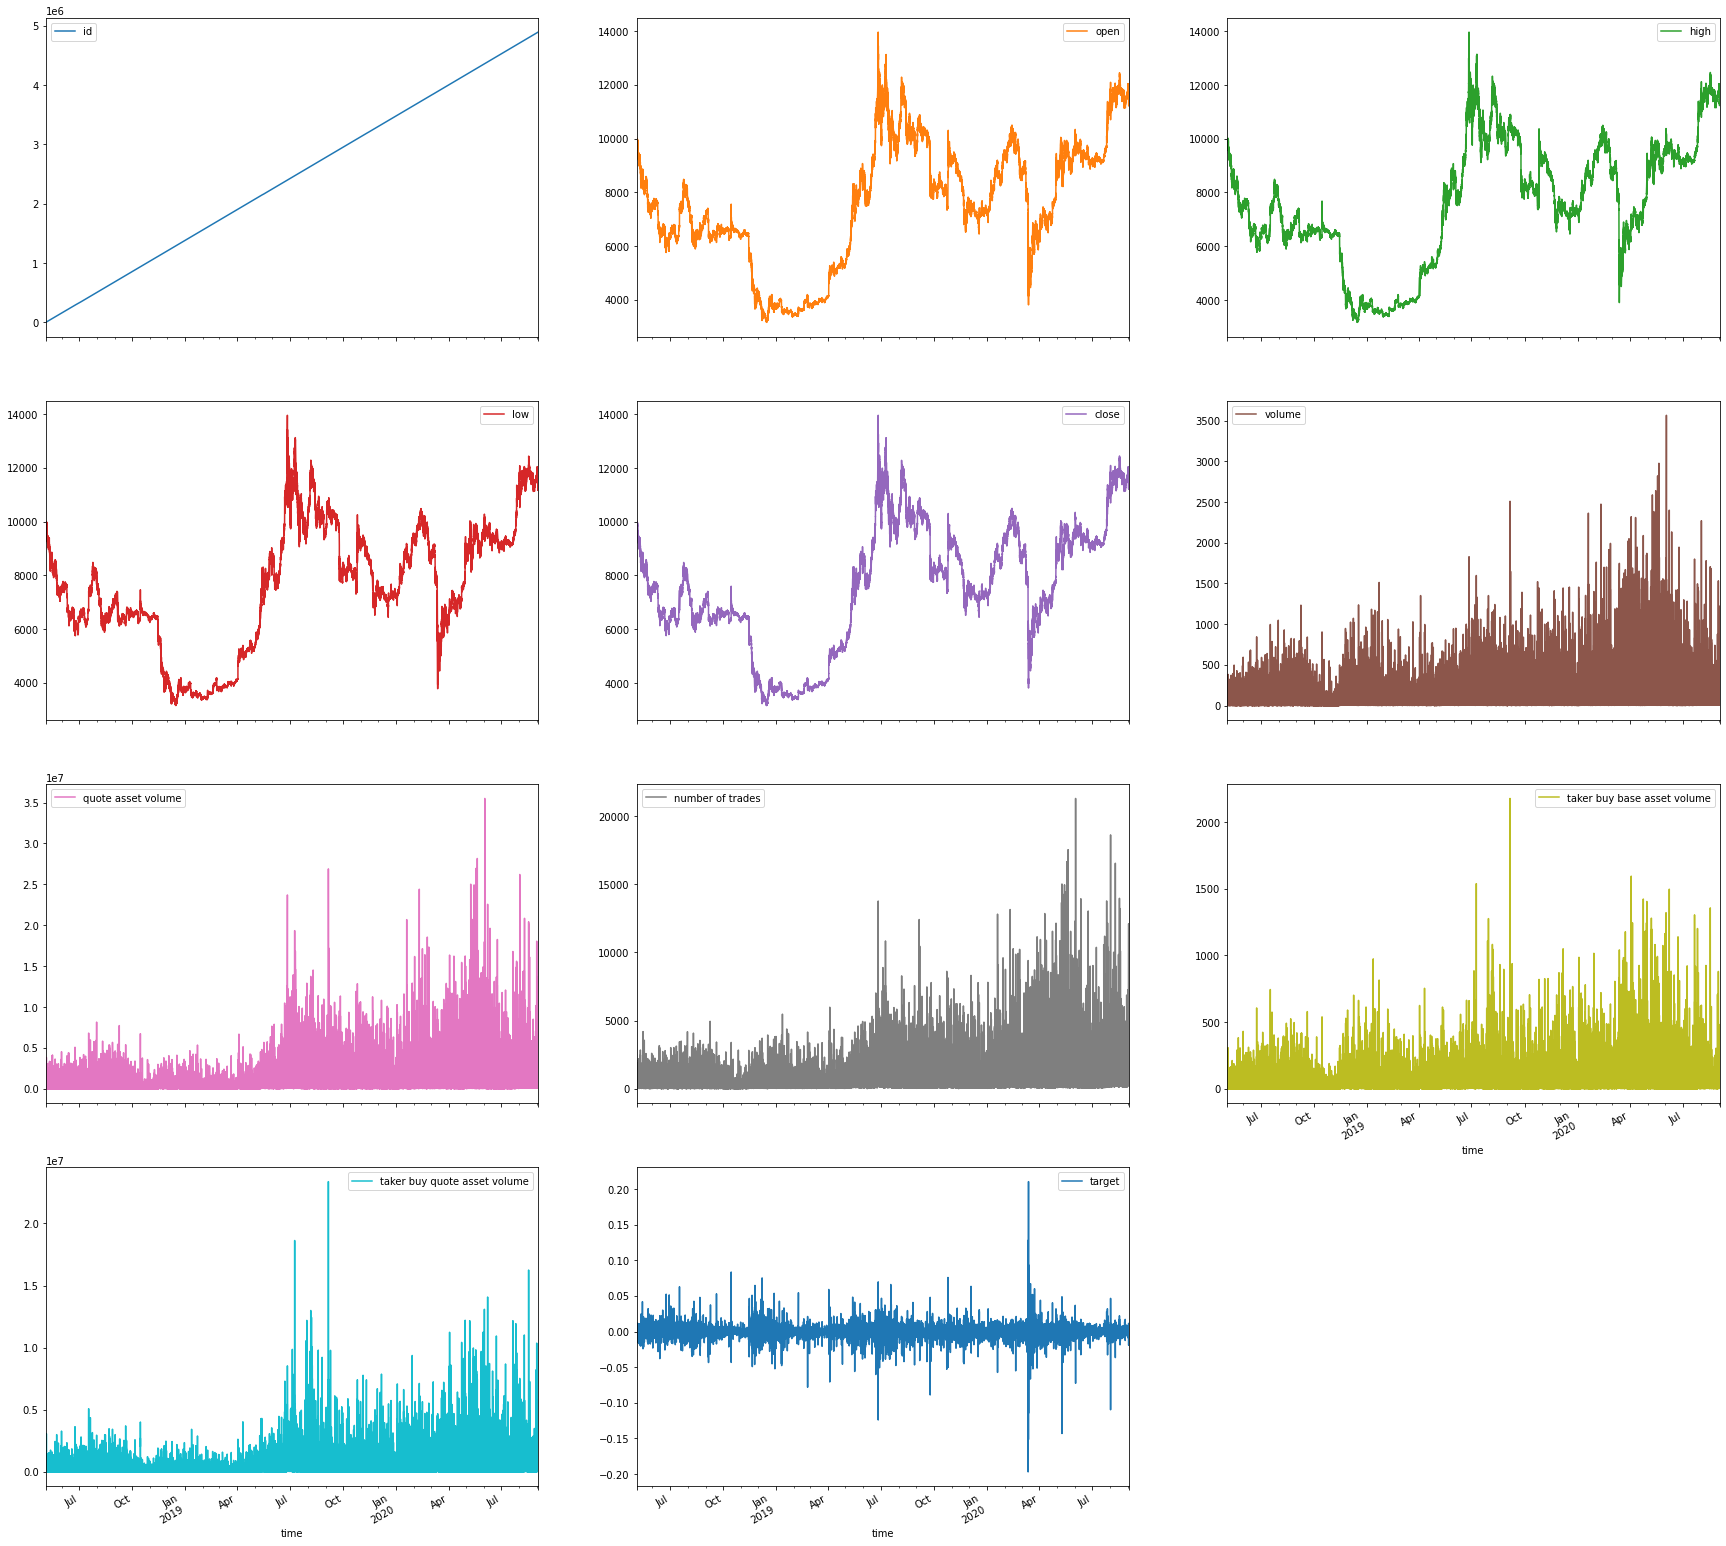

In [ ]:
if action == '1' or action == '4':
  dv(BTCUSDT_Training_Data)

                                  open      high       low     close  \
open                          1.000000  0.999996  0.999995  0.999994   
high                          0.999996  1.000000  0.999991  0.999996   
low                           0.999995  0.999991  1.000000  0.999996   
close                         0.999994  0.999996  0.999996  1.000000   
volume                        0.068039  0.069285  0.066313  0.067797   
quote asset volume            0.221188  0.222363  0.219473  0.220917   
number of trades              0.265181  0.266388  0.263539  0.264968   
taker buy base asset volume   0.056794  0.058328  0.055671  0.057233   
taker buy quote asset volume  0.205955  0.207421  0.204860  0.206376   
target                       -0.004498 -0.004516 -0.004560 -0.004559   

                                volume  quote asset volume  number of trades  \
open                          0.068039            0.221188          0.265181   
high                          0.069285         

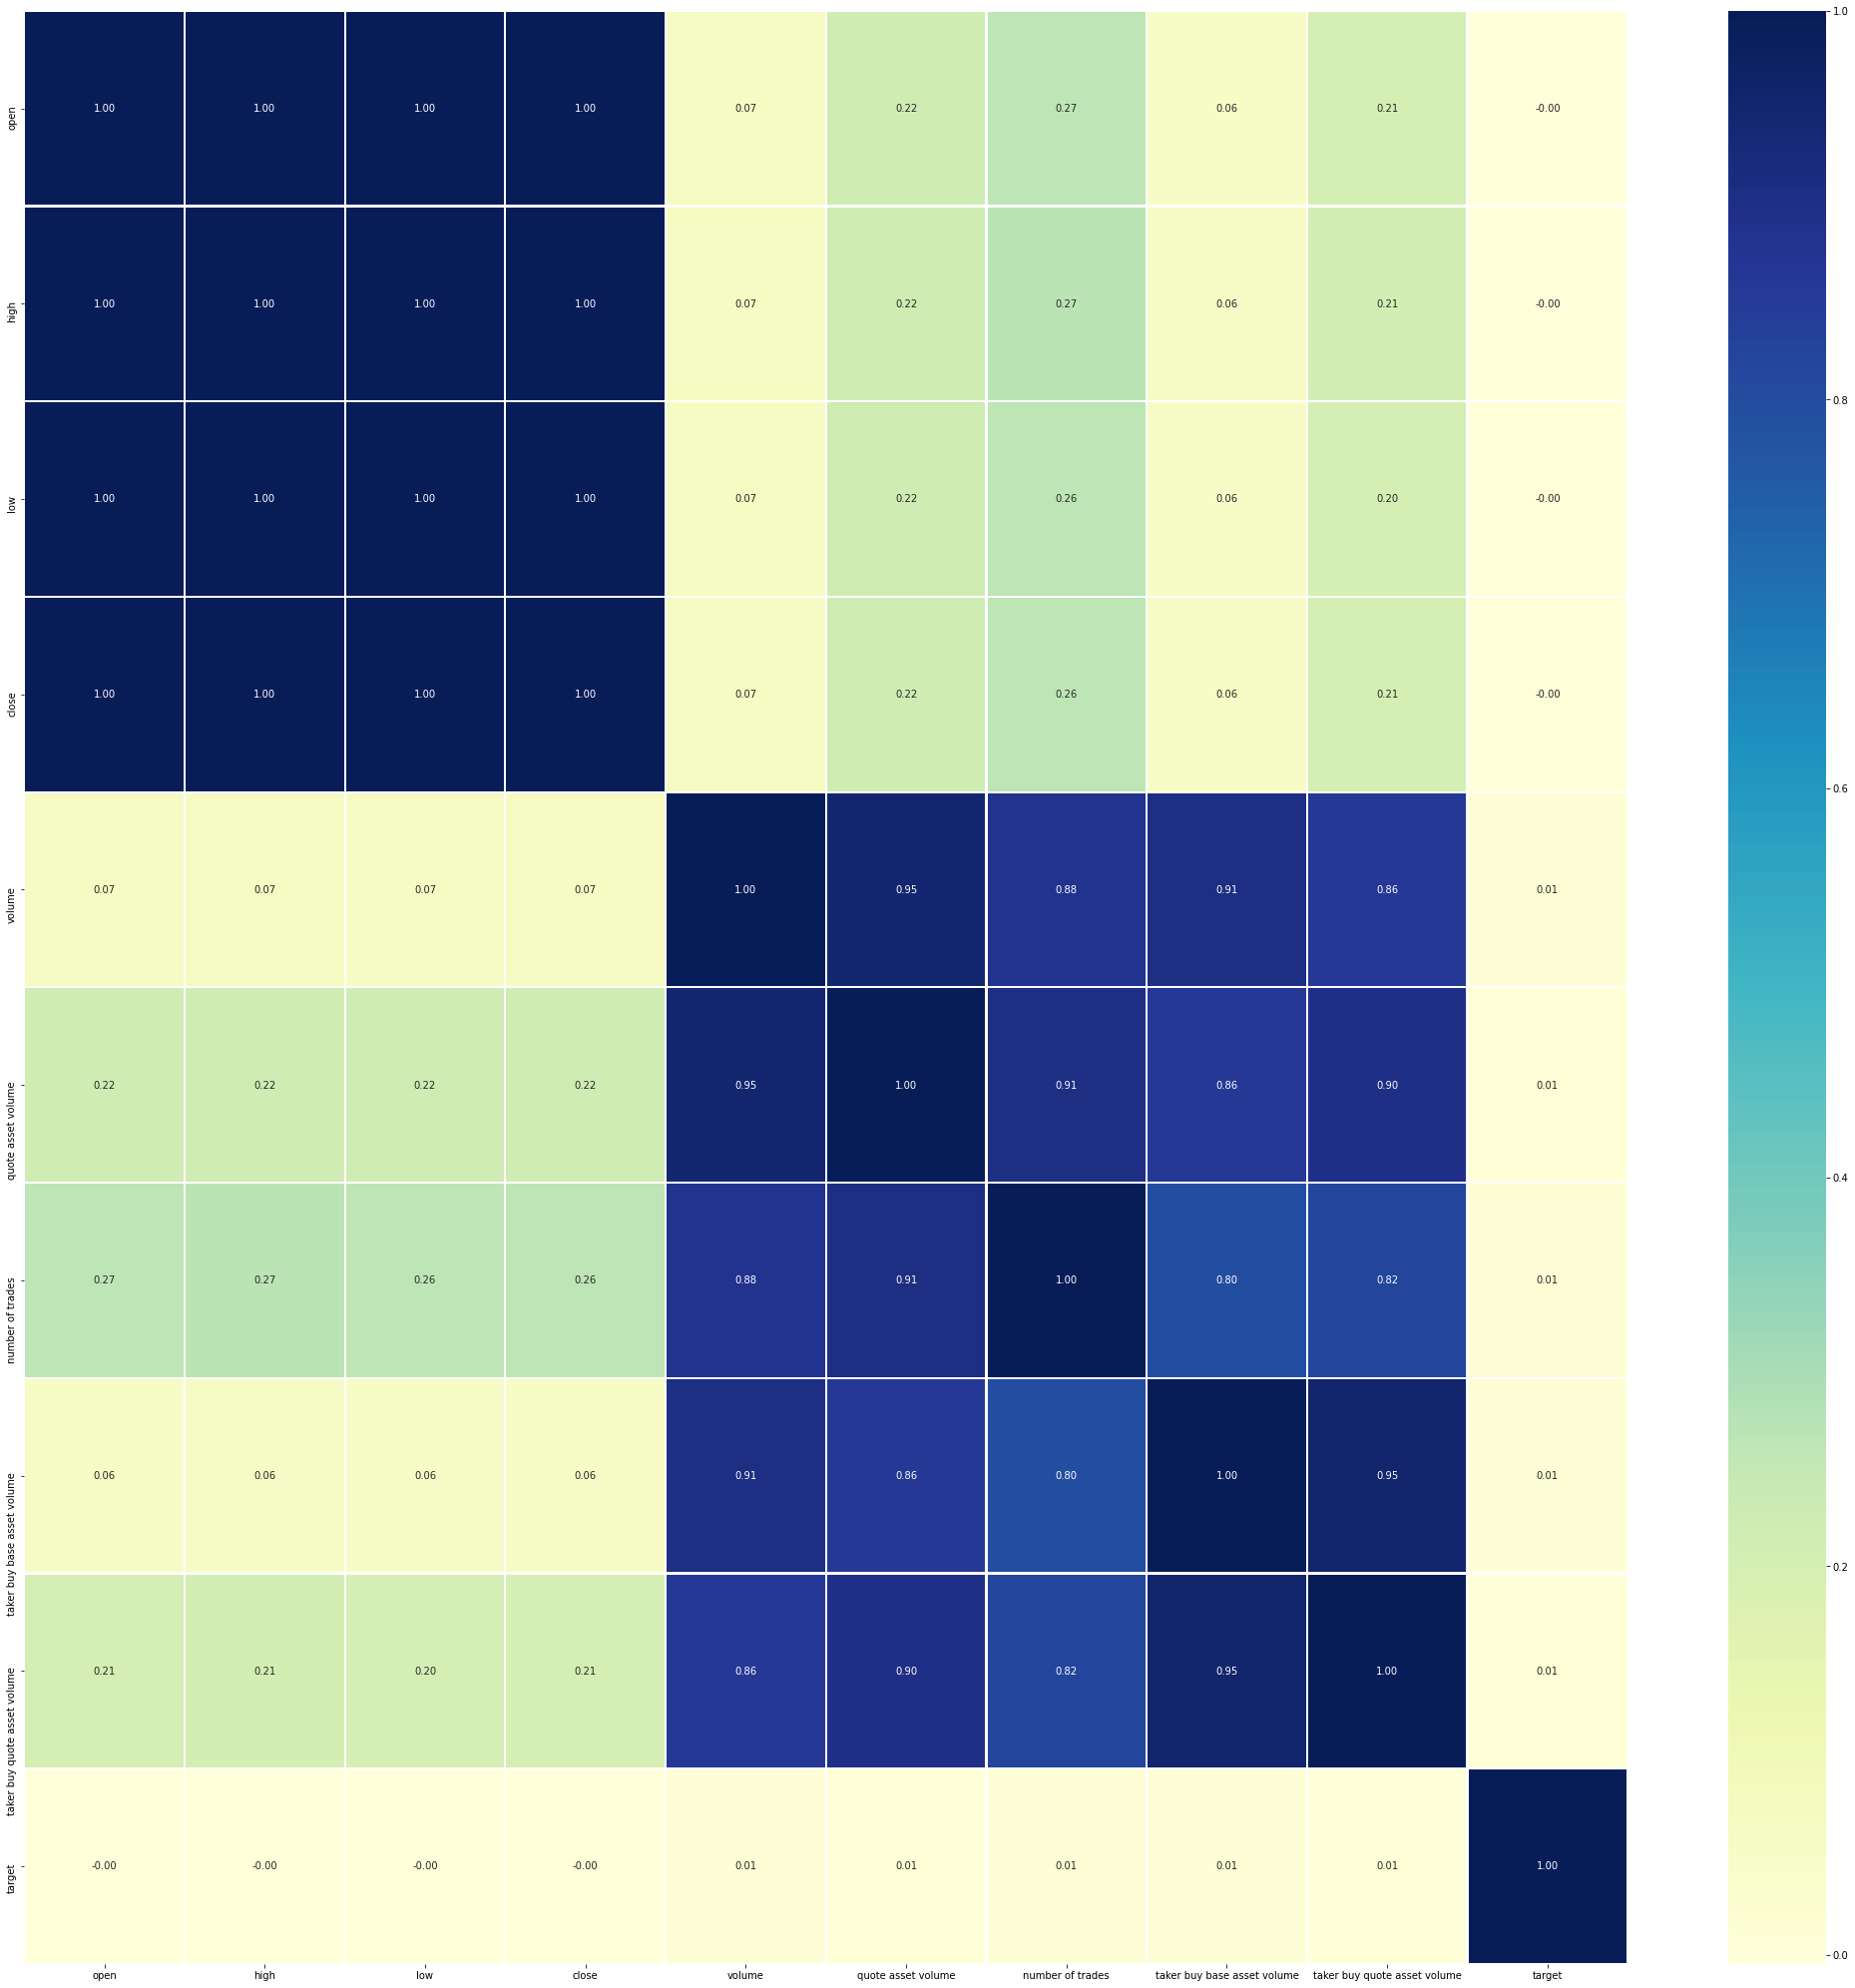

In [ ]:
if action == '1' or action == '4':
  corr(BTCUSDT_Training_Data, 'BTCUSDT')

In [ ]:
if action == '1':
  BTCUSDT_Training_Data.to_csv(folder + "BTCUSDT_Training_Data.csv", index=True)

In [ ]:
# if action == '3':
#   BTCUSDT_Testing_Data.to_csv(folder + "BTCUSDT_Testing_Data.csv", index=True)

In [ ]:
if action == '2':
  BTCUSDT_Training_Data = readCsvData(folder + "BTCUSDT_Training_Data.csv", 0)

In [ ]:
# if action == '3':
#   BTCUSDT_Testing_Data = readCsvData(folder + "BTCUSDT_Testing_Data.csv", 0)

#### Multivariate Time Series

In [ ]:
# lag = 1
# mtsModel = mts(id, crypto, feature, output, BTCUSDT_Training_Data, 1)
# autolag
if action == '2' or action == '4':
  mtsModel = mts(id, crypto, feature, output, BTCUSDT_Training_Data, "auto")
  saveModel(mtsModel, folder + "BTCUSDTmtsModel.pkl")

                               open      high       low     close      volume  \
time                                                                            
2018-05-04 08:12:00+00:00   9727.90   9750.00   9727.90   9745.56   52.086680   
2018-05-04 08:13:00+00:00   9745.56   9750.00   9727.93   9749.92   32.882566   
2018-05-04 08:14:00+00:00   9749.93   9780.00   9747.23   9780.00   84.686332   
2018-05-04 08:15:00+00:00   9780.00   9800.07   9770.38   9780.00  174.356563   
2018-05-04 08:16:00+00:00   9780.00   9786.20   9750.00   9765.63   51.487033   
...                             ...       ...       ...       ...         ...   
2020-09-02 21:05:00+00:00  11339.52  11343.70  11338.73  11341.87   12.533166   
2020-09-02 21:06:00+00:00  11341.87  11343.99  11341.87  11343.35   13.950993   
2020-09-02 21:07:00+00:00  11343.34  11352.41  11343.34  11350.53   24.315317   
2020-09-02 21:08:00+00:00  11350.54  11352.42  11350.52  11351.18    8.093018   
2020-09-02 21:09:00+00:00  1

/usr/local/lib/python3.7/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning:

y is a deprecated alias for endog, will be removed in version 0.11.0



model_fit.y
[[9.72790000e+03 9.75000000e+03 9.72790000e+03 ... 3.92583360e+01
  3.82501195e+05 5.88116337e-03]
 [9.74556000e+03 9.75000000e+03 9.72793000e+03 ... 2.14242350e+01
  2.08845958e+05 5.53693942e-03]
 [9.74993000e+03 9.78000000e+03 9.74723000e+03 ... 7.24060740e+01
  7.06649477e+05 1.93147365e-03]
 ...
 [8.04661000e+03 8.04745000e+03 8.03968000e+03 ... 8.17100400e+00
  6.57056294e+04 1.02661885e-03]
 [8.04114000e+03 8.04218000e+03 8.03982000e+03 ... 5.15629000e+00
  4.14593065e+04 1.72715477e-03]
 [8.03984000e+03 8.03997000e+03 8.03294000e+03 ... 6.24281100e+00
  5.01726332e+04 2.25639859e-03]]
train.values[-lag_order:]
[[ 8.06789000e+03  8.06800000e+03  8.05417000e+03  8.05417000e+03
   1.48545600e+01  1.19759019e+05  2.38000000e+02  5.52493200e+00
   4.45454109e+04 -2.16990456e-03]
 [ 8.05418000e+03  8.05681000e+03  8.04693000e+03  8.04702000e+03
   9.81586700e+00  7.90318904e+04  1.98000000e+02  6.58542300e+00
   5.30186823e+04 -8.72644878e-04]
 [ 8.04799000e+03  8.0480000

## BTCUSDT Prediction Model

#### Multivariate Time Series Predict

In [ ]:
if action == '3':
  model = loadModel(folder + "BTCUSDTmtsModel.pkl")
  pred = mtsPredict(id, crypto, output, BTCUSDT_Testing_Data, model)
if action == '4':
  model = mtsModel
  pred = mtsPredict(id, crypto, output, BTCUSDT_Testing_Data, model)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning:

y is a deprecated alias for endog, will be removed in version 0.11.0



In [ ]:
if action == '3' or action == '4':
  BTCUSDT_Testing_Data_no_tz = BTCUSDT_Testing_Data.reset_index()[["id"]].copy()
  BTCUSDT_submission = pd.concat([BTCUSDT_Testing_Data_no_tz, pred], axis=1)

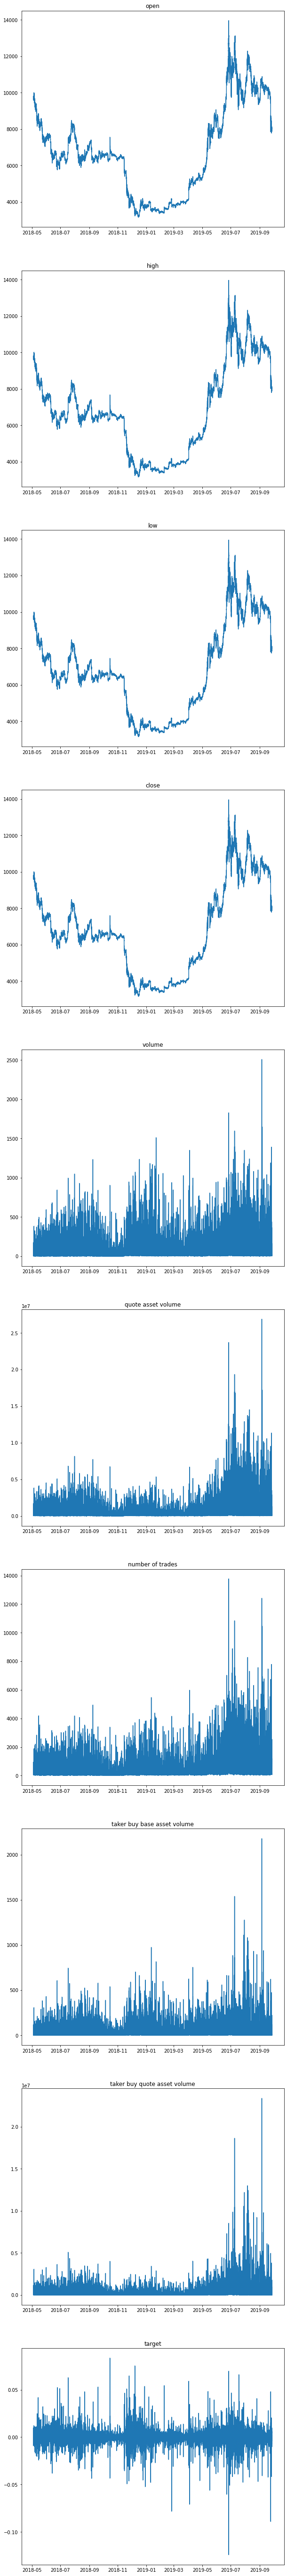

In [ ]:
if action == '3' or action == '4':
  fig = model.plot()
  # fig.tight_layout()
  fig.set_figheight(100)
  # fig.set_figwidth(100)

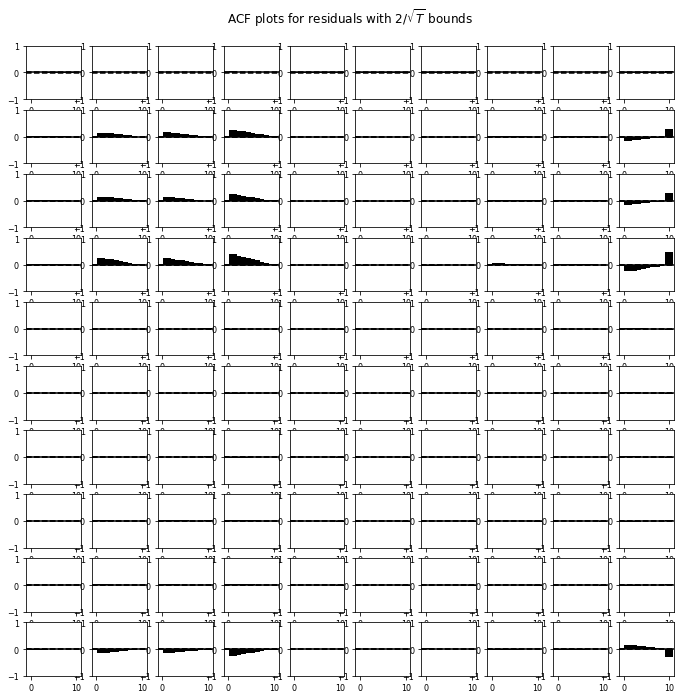

In [ ]:
if action == '3' or action == '4':
  model.plot_acorr()

In [ ]:
now = datetime.now()
E_timestamp = datetime.timestamp(now)
print("Start Time =", s_now)
print("End Time =", now)
Total = E_timestamp - S_timestamp
print("Total Time = " + str(Total/60) + " mins")

Start Time = 2021-05-02 01:08:32.189715
End Time = 2021-05-02 01:27:04.717754
Total Time = 18.542133982976278 mins


## ETHUSDT

In [ ]:
s_now = datetime.now()
S_timestamp = datetime.timestamp(s_now)
print("Start Time =", s_now)

Start Time = 2021-05-02 01:27:04.731622


#### Get Corresponding Data

In [ ]:
if action == '1' or action == '4':
  ETHUSDT_Training_Data = rawtrainingdata.loc[rawtrainingdata[crypto] == 'ETHUSDT']
if action == '3' or action == '4':
  ETHUSDT_Testing_Data = rawtestingdata.loc[rawtestingdata[crypto] == 'ETHUSDT']

In [ ]:
if action == '1' or action == '4':
  print(ETHUSDT_Training_Data)

                                id     name    Open    High     Low   Close  \
time                                                                          
2018-05-04 08:12:00+00:00        2  ETHUSDT  789.08  791.00  789.08  790.93   
2018-05-04 08:13:00+00:00        6  ETHUSDT  790.93  792.60  790.33  792.50   
2018-05-04 08:14:00+00:00       10  ETHUSDT  791.78  794.76  791.10  794.02   
2018-05-04 08:15:00+00:00       14  ETHUSDT  794.10  795.30  793.13  794.05   
2018-05-04 08:16:00+00:00       18  ETHUSDT  794.00  794.97  791.08  791.13   
...                            ...      ...     ...     ...     ...     ...   
2020-09-02 21:05:00+00:00  4892847  ETHUSDT  434.96  435.00  434.95  434.99   
2020-09-02 21:06:00+00:00  4892851  ETHUSDT  434.98  435.55  434.98  435.49   
2020-09-02 21:07:00+00:00  4892855  ETHUSDT  435.49  435.55  435.25  435.25   
2020-09-02 21:08:00+00:00  4892859  ETHUSDT  435.25  435.27  435.10  435.15   
2020-09-02 21:09:00+00:00  4892863  ETHUSDT  435.15 

In [ ]:
if action == '3' or action == '4':
  print(ETHUSDT_Testing_Data)

                                id     name     Open     High      Low  \
time                                                                     
2020-09-02 21:10:00+00:00  4892867  ETHUSDT   435.35   435.50   435.33   
2020-09-02 21:11:00+00:00  4892871  ETHUSDT   435.48   435.50   435.16   
2020-09-02 21:12:00+00:00  4892875  ETHUSDT   435.27   435.27   434.95   
2020-09-02 21:13:00+00:00  4892879  ETHUSDT   434.96   435.05   434.67   
2020-09-02 21:14:00+00:00  4892883  ETHUSDT   434.76   434.85   434.75   
...                            ...      ...      ...      ...      ...   
2021-01-30 21:06:00+00:00  5755460  ETHUSDT  1376.28  1377.37  1376.10   
2021-01-30 21:07:00+00:00  5755464  ETHUSDT  1377.11  1377.65  1375.76   
2021-01-30 21:08:00+00:00  5755468  ETHUSDT  1375.82  1377.16  1375.60   
2021-01-30 21:09:00+00:00  5755472  ETHUSDT  1375.88  1375.89  1375.00   
2021-01-30 21:10:00+00:00  5755476  ETHUSDT  1375.69  1375.72  1374.38   

                             Close   

#### Data Preparation

In [ ]:
if action == '1' or action == '4':
  ETHUSDT_Training_Data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume', 'Quote asset volume': 'quote asset volume', 'Number of trades': 'number of trades', 'Taker buy base asset volume': 'taker buy base asset volume', 'Taker buy quote asset volume': 'taker buy quote asset volume'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
if action == '3' or action == '4':
  ETHUSDT_Testing_Data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume', 'Quote asset volume': 'quote asset volume', 'Number of trades': 'number of trades', 'Taker buy base asset volume': 'taker buy base asset volume', 'Taker buy quote asset volume': 'taker buy quote asset volume'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# if action == '1' or action == '4':
#   ETHUSDT_Training_Data, feature = dp1(ETHUSDT_Training_Data, feature)

In [ ]:
# if action == '3':
#   ETHUSDT_Testing_Data, feature = dp1(ETHUSDT_Testing_Data, feature)
# if action == '4':
#   ETHUSDT_Testing_Data, _ = dp1(ETHUSDT_Testing_Data, feature)

In [ ]:
# if action == '1' or action == '4':
#   ETHUSDT_Training_Data, feature = dp2(ETHUSDT_Training_Data, feature)

In [ ]:
# if action == '3':
#   ETHUSDT_Testing_Data, feature = dp2(ETHUSDT_Testing_Data, feature)
# if action == '4':
#   ETHUSDT_Testing_Data, _ = dp2(ETHUSDT_Testing_Data, feature)

- if datetime are duplicate, keep the last occurence
- add freq
- handle null values

In [ ]:
if action == '1' or action == '4':
  ETHUSDT_Training_Data = dp3(ETHUSDT_Training_Data, output)

DatetimeIndex(['2018-05-04 08:12:00+00:00', '2018-05-04 08:13:00+00:00',
               '2018-05-04 08:14:00+00:00', '2018-05-04 08:15:00+00:00',
               '2018-05-04 08:16:00+00:00', '2018-05-04 08:17:00+00:00',
               '2018-05-04 08:18:00+00:00', '2018-05-04 08:19:00+00:00',
               '2018-05-04 08:20:00+00:00', '2018-05-04 08:21:00+00:00',
               ...
               '2020-09-02 21:00:00+00:00', '2020-09-02 21:01:00+00:00',
               '2020-09-02 21:02:00+00:00', '2020-09-02 21:03:00+00:00',
               '2020-09-02 21:04:00+00:00', '2020-09-02 21:05:00+00:00',
               '2020-09-02 21:06:00+00:00', '2020-09-02 21:07:00+00:00',
               '2020-09-02 21:08:00+00:00', '2020-09-02 21:09:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=1223216, freq=None)
Index(['id', 'name', 'open', 'high', 'low', 'close', 'volume',
       'quote asset volume', 'number of trades', 'taker buy base asset volume',
       'taker buy quote 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



- SMA 10
- RSI 14
- MACD 12

In [ ]:
# if action == '1' or action == '4':
#   ETHUSDT_Training_Data, _ = dp4(ETHUSDT_Training_Data, feature)

In [ ]:
# if action == '3' or action == '4':
#   ETHUSDT_Testing_Data, _ = dp4(ETHUSDT_Testing_Data, feature)

In [ ]:
# if action == '1' or action == '4':
#   ETHUSDT_Training_Data, _ = dp5(ETHUSDT_Training_Data, feature)

In [ ]:
# if action == '3' or action == '4':
#   ETHUSDT_Testing_Data, _ = dp5(ETHUSDT_Testing_Data, feature)

In [ ]:
# if action == '1' or action == '4':
#   ETHUSDT_Training_Data, _ = dp6(ETHUSDT_Training_Data, feature)

In [ ]:
# if action == '3' or action == '4':
#   ETHUSDT_Testing_Data, _ = dp6(ETHUSDT_Testing_Data, feature)

In [ ]:
# if action == '1' or action == '4':
#   del ETHUSDT_Training_Data['open']
#   del ETHUSDT_Training_Data['high']
#   del ETHUSDT_Training_Data['low']
#   del ETHUSDT_Training_Data['close']

In [ ]:
# if action == '3' or action == '4':
#   del ETHUSDT_Testing_Data['open']
#   del ETHUSDT_Testing_Data['high']
#   del ETHUSDT_Testing_Data['low']
#   del ETHUSDT_Testing_Data['close']

#### Data Visualization

In [ ]:
if action == '1' or action == '4':
  ETHUSDT_Training_Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1227658 entries, 2018-05-04 08:12:00+00:00 to 2020-09-02 21:09:00+00:00
Freq: T
Data columns (total 12 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   id                            1227658 non-null  float64
 1   name                          1227658 non-null  object 
 2   open                          1227658 non-null  float64
 3   high                          1227658 non-null  float64
 4   low                           1227658 non-null  float64
 5   close                         1227658 non-null  float64
 6   volume                        1227658 non-null  float64
 7   quote asset volume            1227658 non-null  float64
 8   number of trades              1227658 non-null  float64
 9   taker buy base asset volume   1227658 non-null  float64
 10  taker buy quote asset volume  1227658 non-null  float64
 11  target                        122765

In [ ]:
if action == '1' or action == '4':
  ETHUSDT_Training_Data.describe()

In [ ]:
if action == '3' or action == '4':
  ETHUSDT_Testing_Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215653 entries, 2020-09-02 21:10:00+00:00 to 2021-01-30 21:10:00+00:00
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            215653 non-null  int64  
 1   name                          215653 non-null  object 
 2   open                          215653 non-null  float64
 3   high                          215653 non-null  float64
 4   low                           215653 non-null  float64
 5   close                         215653 non-null  float64
 6   volume                        215653 non-null  float64
 7   quote asset volume            215653 non-null  float64
 8   number of trades              215653 non-null  int64  
 9   taker buy base asset volume   215653 non-null  float64
 10  taker buy quote asset volume  215653 non-null  float64
dtypes: float64(8), int64(2), object(1)
memory usage: 19.7+ MB


In [ ]:
if action == '3' or action == '4':
  ETHUSDT_Testing_Data.describe()

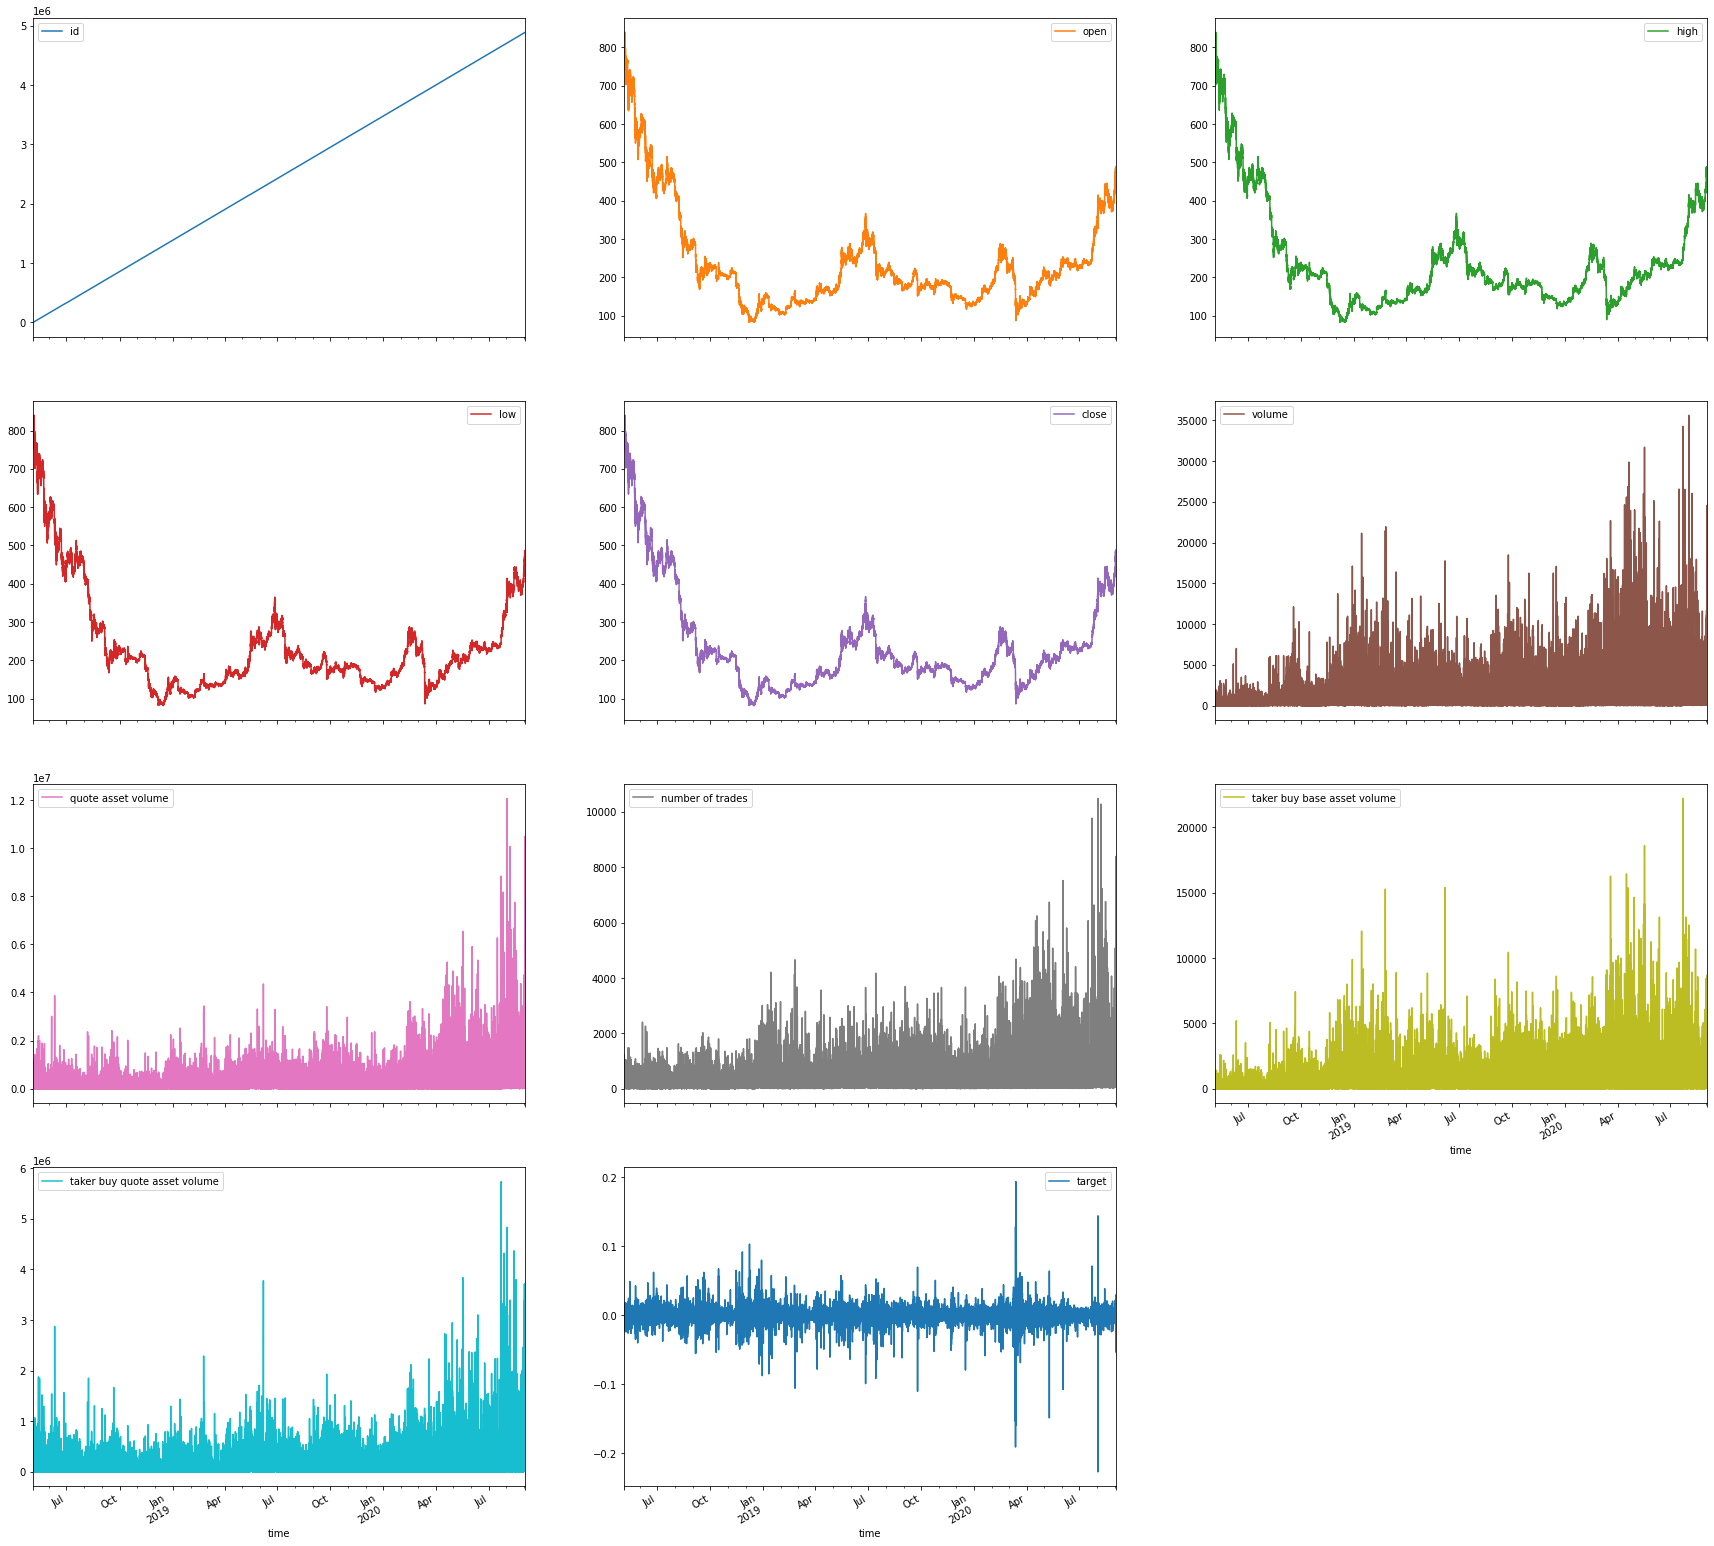

In [ ]:
if action == '1' or action == '4':
  dv(ETHUSDT_Training_Data)

                                  open      high       low     close  \
open                          1.000000  0.999998  0.999997  0.999997   
high                          0.999998  1.000000  0.999996  0.999998   
low                           0.999997  0.999996  1.000000  0.999998   
close                         0.999997  0.999998  0.999998  1.000000   
volume                       -0.076670 -0.076019 -0.077522 -0.076766   
quote asset volume            0.092899  0.093532  0.092019  0.092779   
number of trades              0.005176  0.005934  0.004185  0.005062   
taker buy base asset volume  -0.072000 -0.071227 -0.072589 -0.071799   
taker buy quote asset volume  0.090063  0.090832  0.089474  0.090274   
target                       -0.006921 -0.006909 -0.006948 -0.006939   

                                volume  quote asset volume  number of trades  \
open                         -0.076670            0.092899          0.005176   
high                         -0.076019         

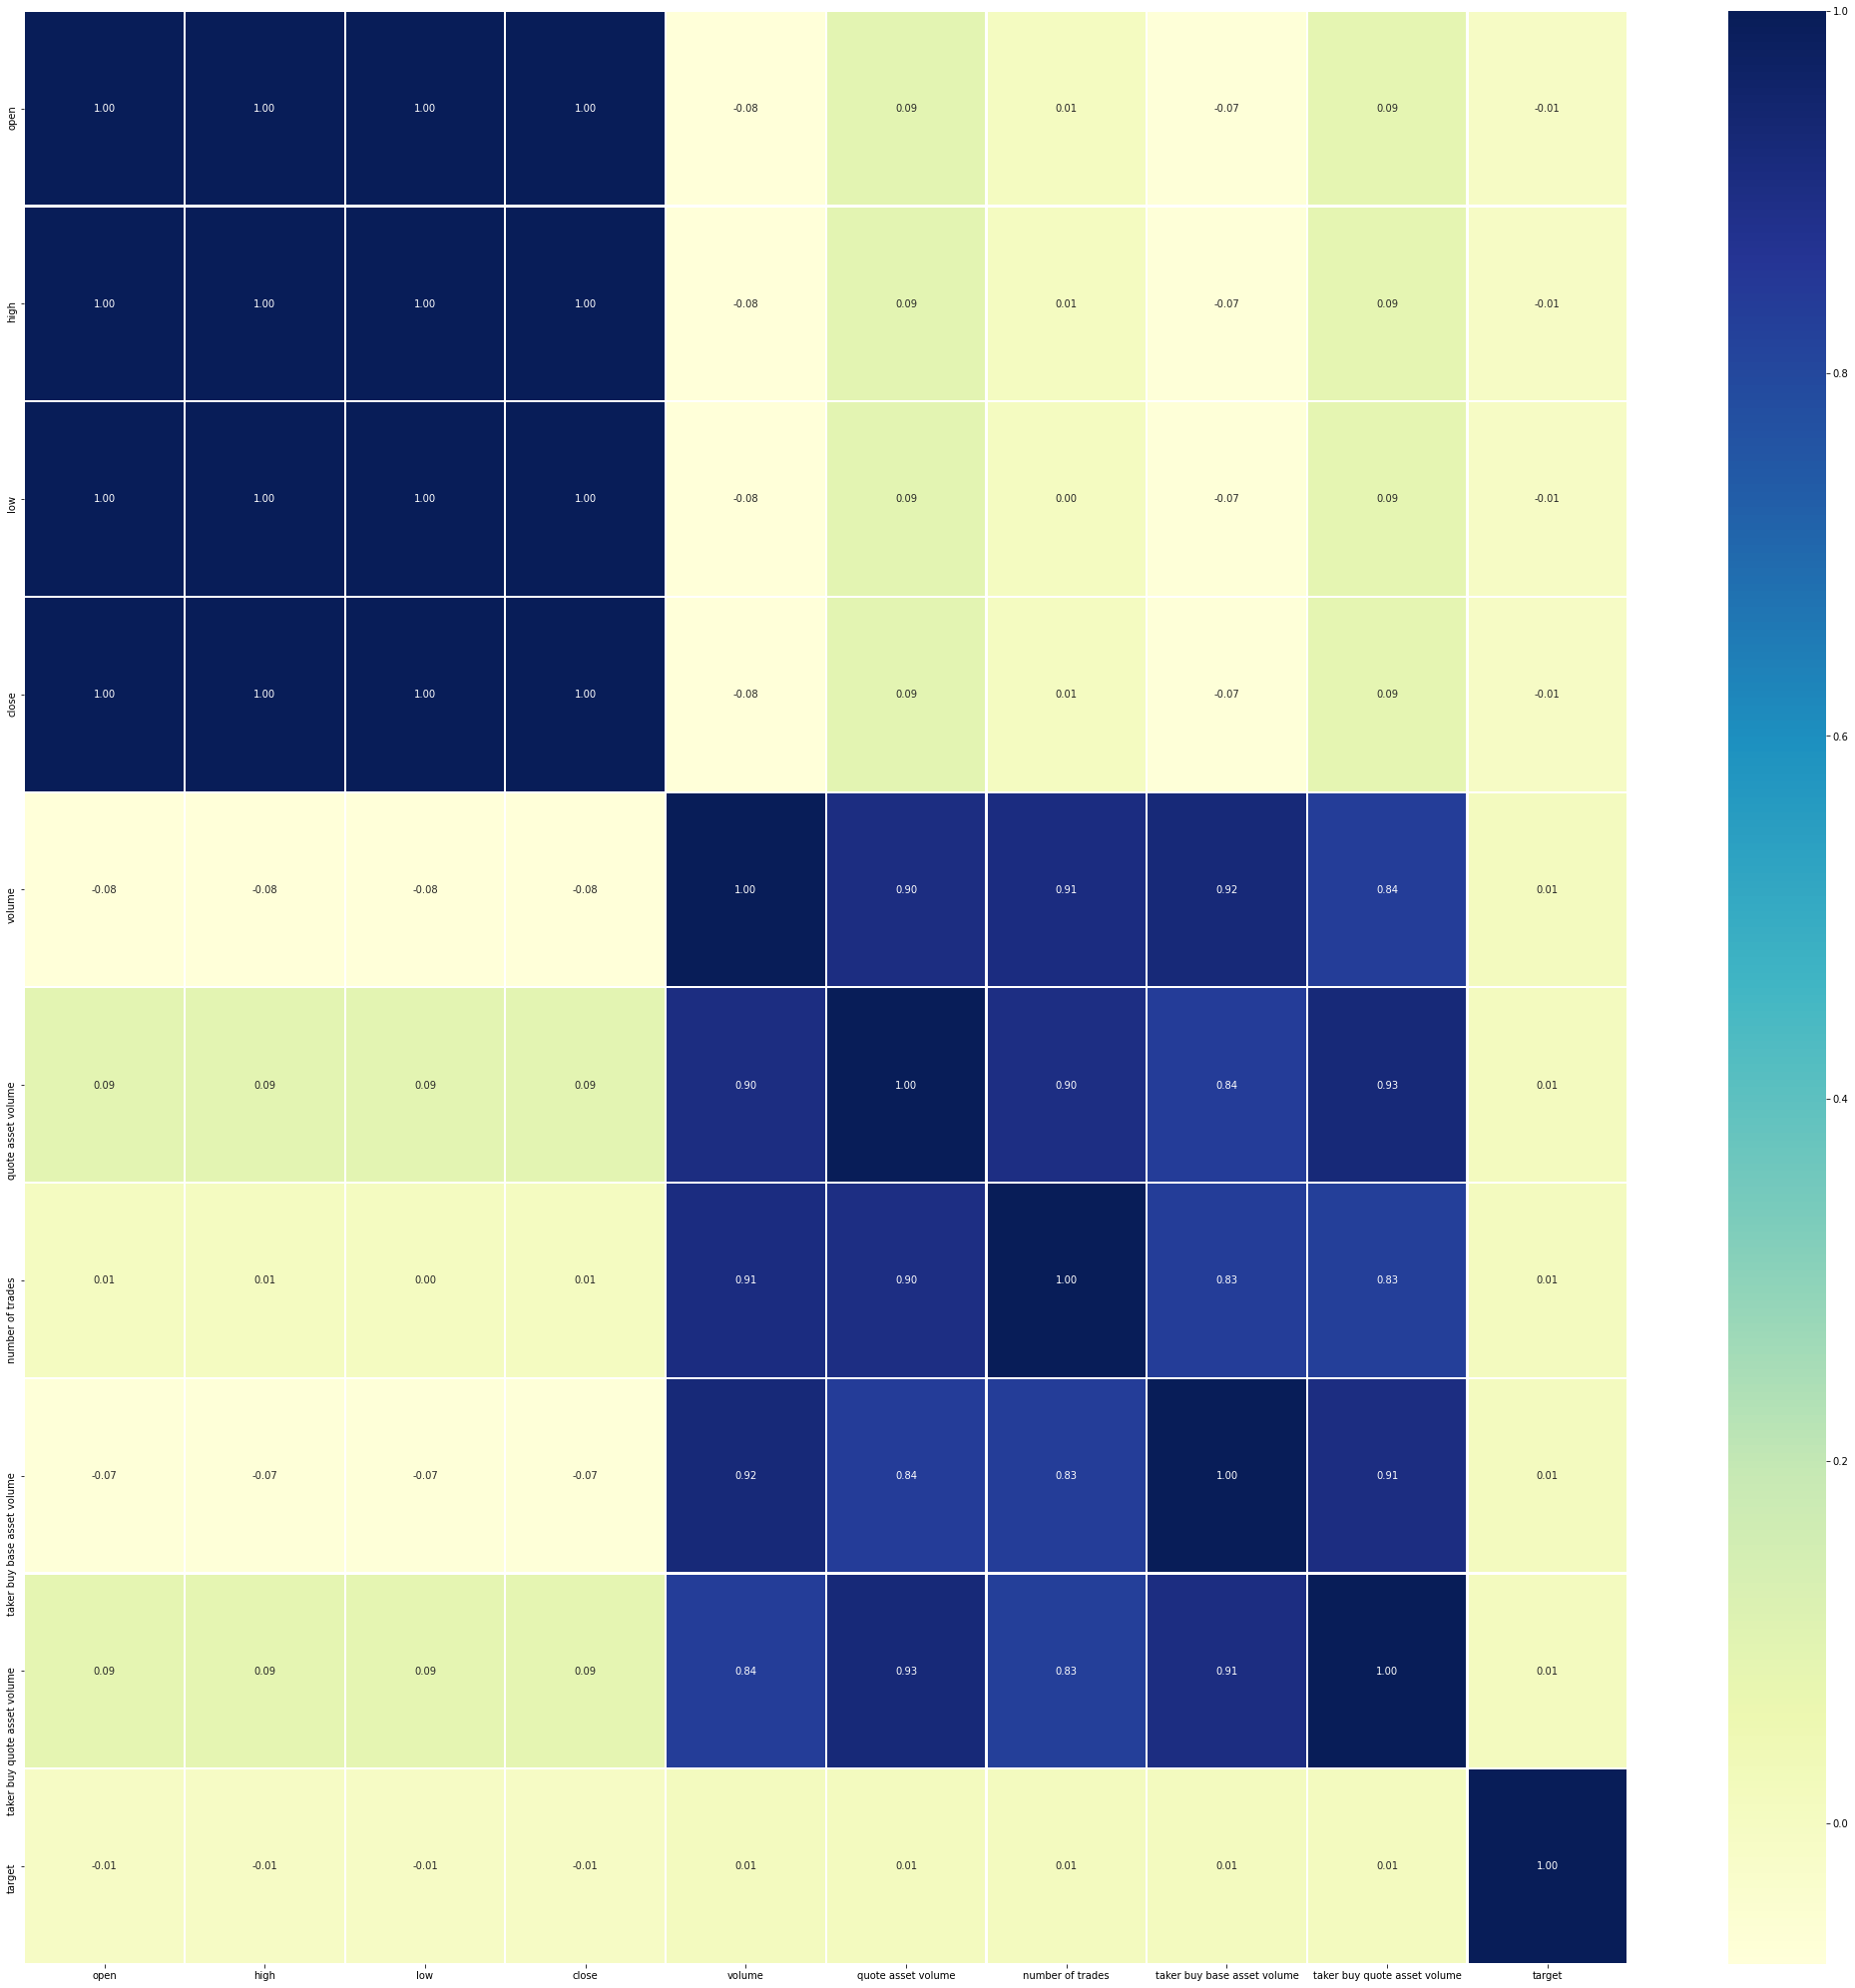

In [ ]:
if action == '1' or action == '4':
  corr(ETHUSDT_Training_Data, 'ETHUSDT')

In [ ]:
if action == '1':
  ETHUSDT_Training_Data.to_csv(folder + "ETHUSDT_Training_Data.csv", index=True)

In [ ]:
# if action == '3':
#   ETHUSDT_Testing_Data.to_csv(folder + "ETHUSDT_Testing_Data.csv", index=True)

In [ ]:
if action == '2':
  ETHUSDT_Training_Data = readCsvData(folder + "ETHUSDT_Training_Data.csv", 0)

In [ ]:
# if action == '3':
#   ETHUSDT_Testing_Data = readCsvData(folder + "ETHUSDT_Testing_Data.csv", 0)

#### Multivariate Time Series

In [ ]:
# lag = 1
# mtsModel = mts(id, crypto, feature, output, ETHUSDT_Training_Data, 1)
# autolag
if action == '2' or action == '4':
  mtsModel = mts(id, crypto, feature, output, ETHUSDT_Training_Data, "auto")
  saveModel(mtsModel, folder + "ETHUSDTmtsModel.pkl")

                             open    high     low   close     volume  \
time                                                                   
2018-05-04 08:12:00+00:00  789.08  791.00  789.08  790.93  407.54477   
2018-05-04 08:13:00+00:00  790.93  792.60  790.33  792.50  329.51504   
2018-05-04 08:14:00+00:00  791.78  794.76  791.10  794.02  257.79828   
2018-05-04 08:15:00+00:00  794.10  795.30  793.13  794.05  821.04933   
2018-05-04 08:16:00+00:00  794.00  794.97  791.08  791.13  417.80230   
...                           ...     ...     ...     ...        ...   
2020-09-02 21:05:00+00:00  434.96  435.00  434.95  434.99  129.24630   
2020-09-02 21:06:00+00:00  434.98  435.55  434.98  435.49  260.89230   
2020-09-02 21:07:00+00:00  435.49  435.55  435.25  435.25  242.74494   
2020-09-02 21:08:00+00:00  435.25  435.27  435.10  435.15  125.45837   
2020-09-02 21:09:00+00:00  435.15  435.34  435.10  435.33  234.93026   

                           quote asset volume  number of trades

/usr/local/lib/python3.7/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning:

y is a deprecated alias for endog, will be removed in version 0.11.0



model_fit.y
[[7.89080000e+02 7.91000000e+02 7.89080000e+02 ... 3.03069270e+02
  2.39530382e+05 4.17095182e-03]
 [7.90930000e+02 7.92600000e+02 7.90330000e+02 ... 1.72609050e+02
  1.36598743e+05 4.15016630e-03]
 [7.91780000e+02 7.94760000e+02 7.91100000e+02 ... 1.64352380e+02
  1.30395501e+05 1.03088904e-03]
 ...
 [1.70410000e+02 1.70420000e+02 1.70230000e+02 ... 2.24671420e+02
  3.82577220e+04 2.44926644e-03]
 [1.70270000e+02 1.70300000e+02 1.70070000e+02 ... 9.45074400e+01
  1.60833083e+04 4.60628784e-03]
 [1.70110000e+02 1.70130000e+02 1.69980000e+02 ... 1.29627524e+03
  2.20378305e+05 5.07452458e-03]]
train.values[-lag_order:]
[[ 1.71260000e+02  1.71330000e+02  1.71000000e+02  1.71040000e+02
   1.13715006e+03  1.94675206e+05  2.44000000e+02  2.23950080e+02
   3.83466858e+04 -5.88802820e-03]
 [ 1.71040000e+02  1.71050000e+02  1.70720000e+02  1.70730000e+02
   8.25678160e+02  1.41086499e+05  2.17000000e+02  3.38435680e+02
   5.78375865e+04 -3.14942521e-03]
 [ 1.70730000e+02  1.7083000

## ETHUSDT Prediction Model

#### Multivariate Time Series Predict

In [ ]:
if action == '3':
  model = loadModel(folder + "ETHUSDTmtsModel.pkl")
  pred = mtsPredict(id, crypto, output, ETHUSDT_Testing_Data, model)
if action == '4':
  model = mtsModel
  pred = mtsPredict(id, crypto, output, ETHUSDT_Testing_Data, model)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning:

y is a deprecated alias for endog, will be removed in version 0.11.0



In [ ]:
if action == '3' or action == '4':
  ETHUSDT_Testing_Data_no_tz = ETHUSDT_Testing_Data.reset_index()[["id"]].copy()
  ETHUSDT_submission = pd.concat( [ETHUSDT_Testing_Data_no_tz, pred], axis=1 )

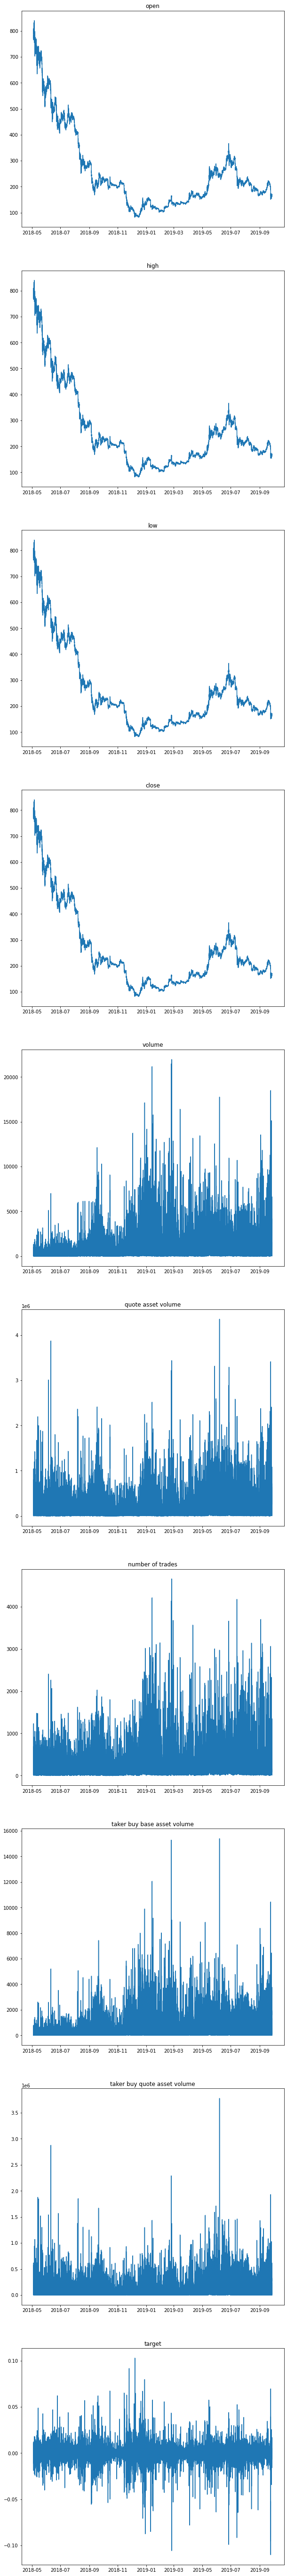

In [ ]:
if action == '3' or action == '4':
  fig = model.plot()
  # fig.tight_layout()
  fig.set_figheight(100)
  # fig.set_figwidth(100)

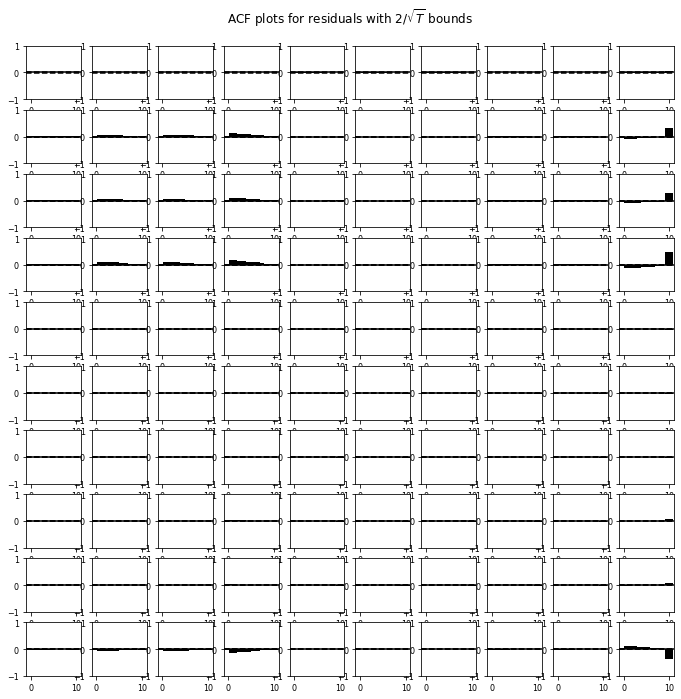

In [ ]:
if action == '3' or action == '4':
  model.plot_acorr()

In [ ]:
now = datetime.now()
E_timestamp = datetime.timestamp(now)
print("Start Time =", s_now)
print("End Time =", now)
Total = E_timestamp - S_timestamp
print("Total Time = " + str(Total/60) + " mins")

Start Time = 2021-05-02 01:27:04.731622
End Time = 2021-05-02 01:45:22.704809
Total Time = 18.299553116162617 mins


## LTCUSDT

In [ ]:
s_now = datetime.now()
S_timestamp = datetime.timestamp(s_now)
print("Start Time =", s_now)

Start Time = 2021-05-02 01:45:22.715907


#### Get Corresponding Data

In [ ]:
if action == '1' or action == '4':
  LTCUSDT_Training_Data = rawtrainingdata.loc[rawtrainingdata[crypto] == 'LTCUSDT']
if action == '3' or action == '4':
  LTCUSDT_Testing_Data = rawtestingdata.loc[rawtestingdata[crypto] == 'LTCUSDT']

In [ ]:
if action == '1' or action == '4':
  LTCUSDT_Training_Data

In [ ]:
if action == '3' or action == '4':
  LTCUSDT_Testing_Data

#### Data Preparation

In [ ]:
if action == '1' or action == '4':
  LTCUSDT_Training_Data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume', 'Quote asset volume': 'quote asset volume', 'Number of trades': 'number of trades', 'Taker buy base asset volume': 'taker buy base asset volume', 'Taker buy quote asset volume': 'taker buy quote asset volume'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
if action == '3' or action == '4':
  LTCUSDT_Testing_Data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume', 'Quote asset volume': 'quote asset volume', 'Number of trades': 'number of trades', 'Taker buy base asset volume': 'taker buy base asset volume', 'Taker buy quote asset volume': 'taker buy quote asset volume'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



- if datetime are duplicate, keep the last occurence
- add freq
- handle null values

In [ ]:
# if action == '1' or action == '4':
#   LTCUSDT_Training_Data, feature = dp1(LTCUSDT_Training_Data, feature)

In [ ]:
# if action == '3':
#   LTCUSDT_Testing_Data, feature = dp1(LTCUSDT_Testing_Data, feature)
# if action == '4':
#   LTCUSDT_Testing_Data, _ = dp1(LTCUSDT_Testing_Data, feature)

In [ ]:
# if action == '1' or action == '4':
#   LTCUSDT_Training_Data, feature = dp2(LTCUSDT_Training_Data, feature)

In [ ]:
# if action == '3':
#   LTCUSDT_Testing_Data, feature = dp2(LTCUSDT_Testing_Data, feature)
# if action == '4':
#   LTCUSDT_Testing_Data, _ = dp2(LTCUSDT_Testing_Data, feature)

In [ ]:
if action == '1' or action == '4':
  LTCUSDT_Training_Data = dp3(LTCUSDT_Training_Data, output)

DatetimeIndex(['2018-05-04 08:12:00+00:00', '2018-05-04 08:13:00+00:00',
               '2018-05-04 08:14:00+00:00', '2018-05-04 08:15:00+00:00',
               '2018-05-04 08:16:00+00:00', '2018-05-04 08:17:00+00:00',
               '2018-05-04 08:18:00+00:00', '2018-05-04 08:19:00+00:00',
               '2018-05-04 08:20:00+00:00', '2018-05-04 08:21:00+00:00',
               ...
               '2020-09-02 21:00:00+00:00', '2020-09-02 21:01:00+00:00',
               '2020-09-02 21:02:00+00:00', '2020-09-02 21:03:00+00:00',
               '2020-09-02 21:04:00+00:00', '2020-09-02 21:05:00+00:00',
               '2020-09-02 21:06:00+00:00', '2020-09-02 21:07:00+00:00',
               '2020-09-02 21:08:00+00:00', '2020-09-02 21:09:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=1223216, freq=None)
Index(['id', 'name', 'open', 'high', 'low', 'close', 'volume',
       'quote asset volume', 'number of trades', 'taker buy base asset volume',
       'taker buy quote 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



- SMA 10
- RSI 14
- MACD 12

In [ ]:
# if action == '1' or action == '4':
#   LTCUSDT_Training_Data, _ = dp4(LTCUSDT_Training_Data, feature)

In [ ]:
# if action == '3' or action == '4':
#   LTCUSDT_Testing_Data, _ = dp4(LTCUSDT_Testing_Data, feature)

In [ ]:
# if action == '1' or action == '4':
#   LTCUSDT_Training_Data, _ = dp5(LTCUSDT_Training_Data, feature)

In [ ]:
# if action == '3' or action == '4':
#   LTCUSDT_Testing_Data, _ = dp5(LTCUSDT_Testing_Data, feature)

In [ ]:
# if action == '1' or action == '4':
#   LTCUSDT_Training_Data, _ = dp6(LTCUSDT_Training_Data, feature)

In [ ]:
# if action == '3' or action == '4':
#   LTCUSDT_Testing_Data, _ = dp6(LTCUSDT_Testing_Data, feature)

In [ ]:
# if action == '1' or action == '4':
#   del LTCUSDT_Training_Data['open']
#   del LTCUSDT_Training_Data['high']
#   del LTCUSDT_Training_Data['low']
#   del LTCUSDT_Training_Data['close']

In [ ]:
# if action == '3' or action == '4':
#   del LTCUSDT_Testing_Data['open']
#   del LTCUSDT_Testing_Data['high']
#   del LTCUSDT_Testing_Data['low']
#   del LTCUSDT_Testing_Data['close']

#### Data Visualization

In [ ]:
if action == '1' or action == '4':
  LTCUSDT_Training_Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1227658 entries, 2018-05-04 08:12:00+00:00 to 2020-09-02 21:09:00+00:00
Freq: T
Data columns (total 12 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   id                            1227658 non-null  float64
 1   name                          1227658 non-null  object 
 2   open                          1227658 non-null  float64
 3   high                          1227658 non-null  float64
 4   low                           1227658 non-null  float64
 5   close                         1227658 non-null  float64
 6   volume                        1227658 non-null  float64
 7   quote asset volume            1227658 non-null  float64
 8   number of trades              1227658 non-null  float64
 9   taker buy base asset volume   1227658 non-null  float64
 10  taker buy quote asset volume  1227658 non-null  float64
 11  target                        122765

In [ ]:
if action == '1' or action == '4':
  LTCUSDT_Training_Data.describe()

In [ ]:
if action == '3' or action == '4':
  LTCUSDT_Testing_Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215653 entries, 2020-09-02 21:10:00+00:00 to 2021-01-30 21:10:00+00:00
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            215653 non-null  int64  
 1   name                          215653 non-null  object 
 2   open                          215653 non-null  float64
 3   high                          215653 non-null  float64
 4   low                           215653 non-null  float64
 5   close                         215653 non-null  float64
 6   volume                        215653 non-null  float64
 7   quote asset volume            215653 non-null  float64
 8   number of trades              215653 non-null  int64  
 9   taker buy base asset volume   215653 non-null  float64
 10  taker buy quote asset volume  215653 non-null  float64
dtypes: float64(8), int64(2), object(1)
memory usage: 19.7+ MB


In [ ]:
if action == '3' or action == '4':
  LTCUSDT_Testing_Data.describe()

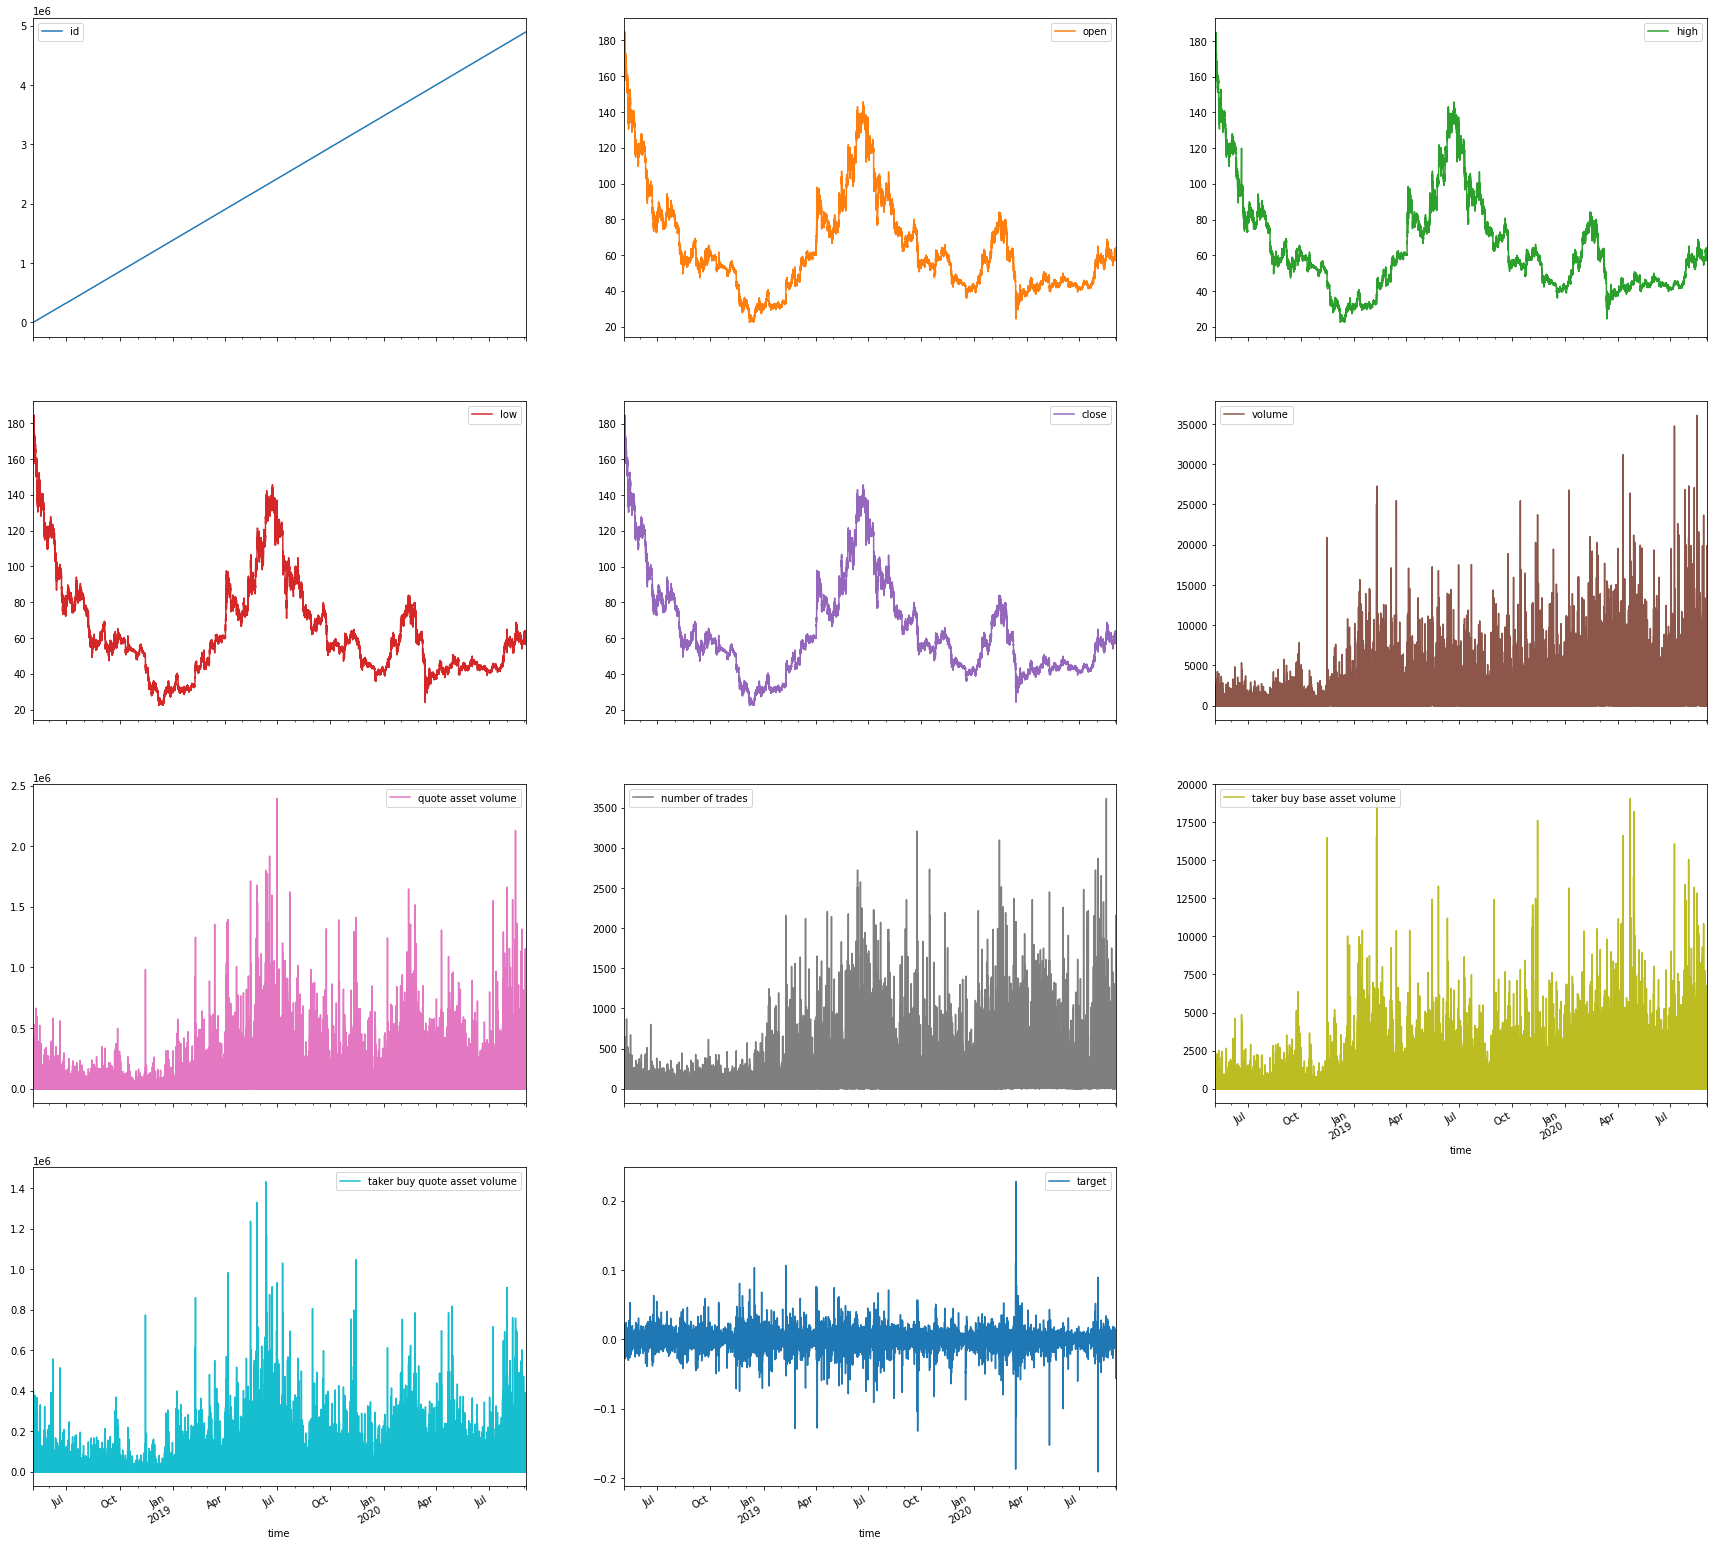

In [ ]:
if action == '1' or action == '4':
  dv(LTCUSDT_Training_Data)

                                  open      high       low     close  \
open                          1.000000  0.999996  0.999995  0.999994   
high                          0.999996  1.000000  0.999992  0.999996   
low                           0.999995  0.999992  1.000000  0.999996   
close                         0.999994  0.999996  0.999996  1.000000   
volume                       -0.029795 -0.028817 -0.031069 -0.029941   
quote asset volume            0.122709  0.123775  0.121301  0.122542   
number of trades              0.071183  0.072397  0.069634  0.071012   
taker buy base asset volume  -0.027649 -0.026477 -0.028497 -0.027308   
taker buy quote asset volume  0.113983  0.115268  0.113061  0.114366   
target                       -0.007493 -0.007499 -0.007541 -0.007578   

                                volume  quote asset volume  number of trades  \
open                         -0.029795            0.122709          0.071183   
high                         -0.028817         

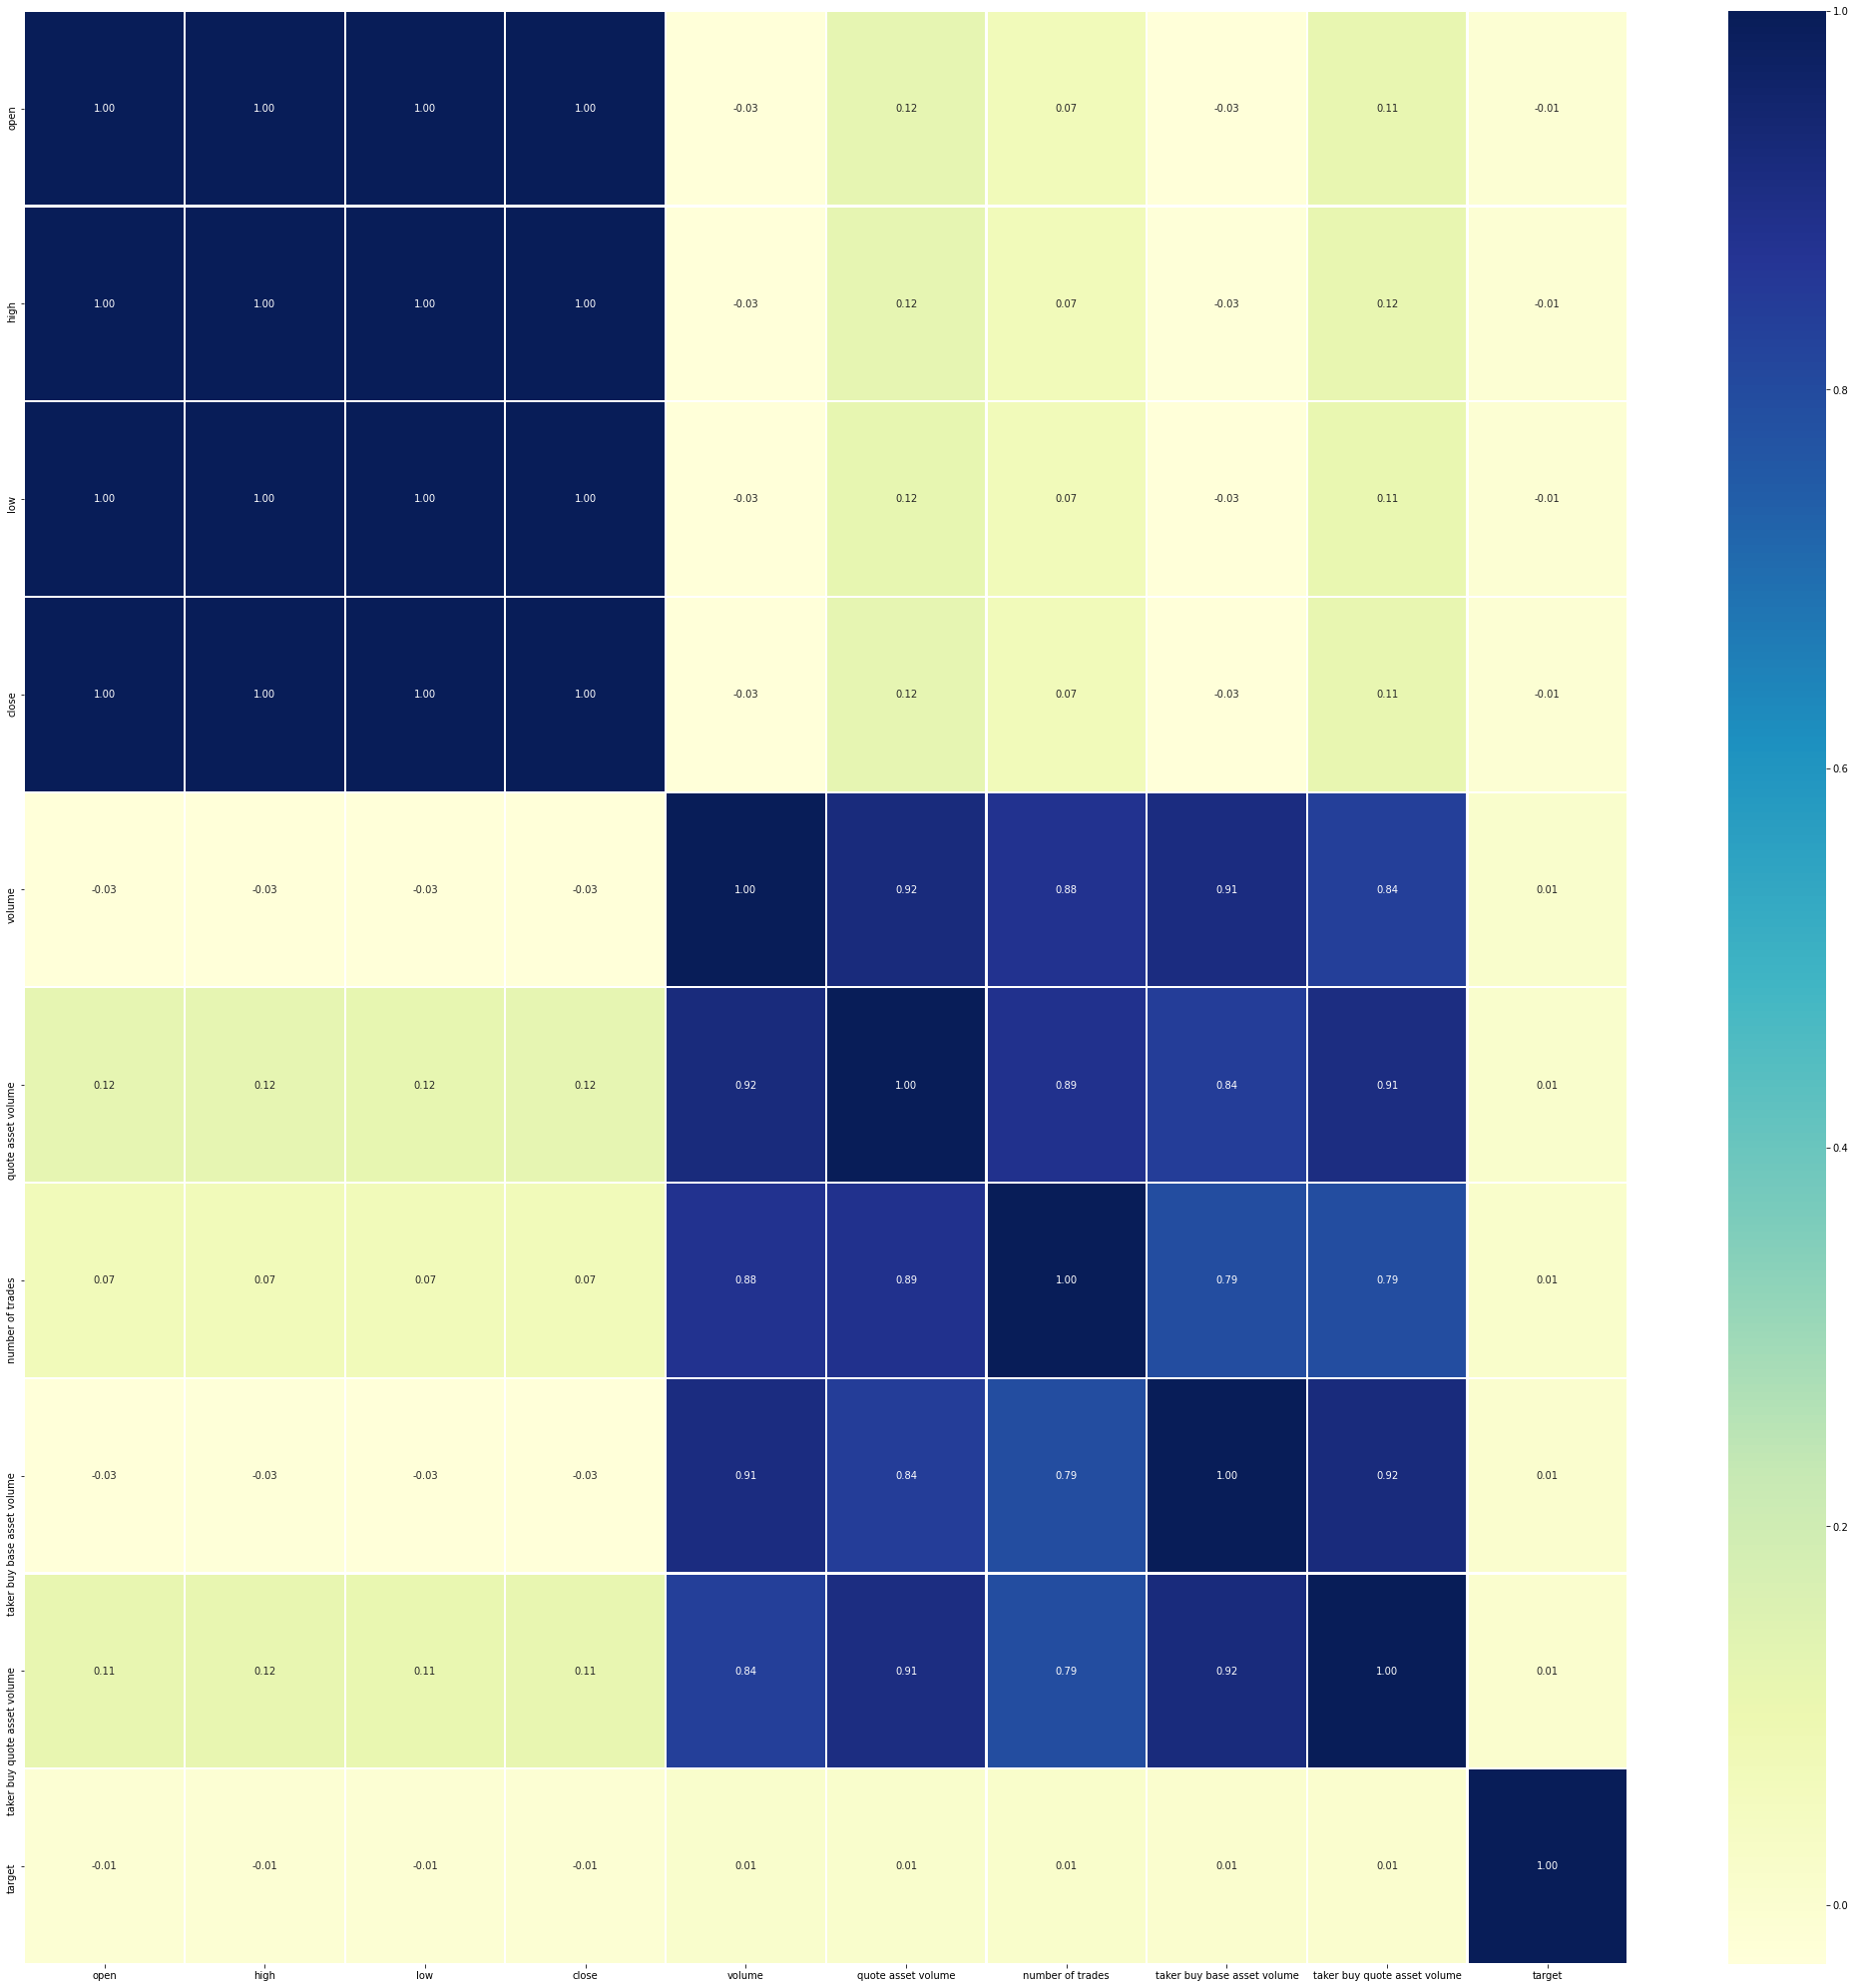

In [ ]:
if action == '1' or action == '4':
  corr(LTCUSDT_Training_Data, 'LTCUSDT')

In [ ]:
if action == '1':
  LTCUSDT_Training_Data.to_csv(folder + "LTCUSDT_Training_Data.csv", index=True)

In [ ]:
# if action == '3':
#   LTCUSDT_Testing_Data.to_csv(folder + "LTCUSDT_Testing_Data.csv", index=True)

In [ ]:
if action == '2':
  LTCUSDT_Training_Data = readCsvData(folder + "LTCUSDT_Training_Data.csv", 0)

In [ ]:
# if action == '3':
#   LTCUSDT_Testing_Data = readCsvData(folder + "LTCUSDT_Testing_Data.csv", 0)

#### Multivariate Time Series

In [ ]:
# lag = 1
# mtsModel = mts(id, crypto, feature, output, LTCUSDT_Training_Data, 1)
# autolag
if action == '2' or action == '4':
  mtsModel = mts(id, crypto, feature, output, LTCUSDT_Training_Data, "auto")
  saveModel(mtsModel, folder + "LTCUSDTmtsModel.pkl")

                             open    high     low   close     volume  \
time                                                                   
2018-05-04 08:12:00+00:00  160.70  161.36  160.52  161.06  208.47051   
2018-05-04 08:13:00+00:00  160.98  161.58  160.97  161.42  133.72628   
2018-05-04 08:14:00+00:00  161.59  162.28  161.27  161.83  218.17150   
2018-05-04 08:15:00+00:00  162.27  162.50  161.83  162.06  537.73024   
2018-05-04 08:16:00+00:00  162.06  162.28  161.46  161.98  411.79161   
...                           ...     ...     ...     ...        ...   
2020-09-02 21:05:00+00:00   57.96   57.97   57.94   57.94   35.83637   
2020-09-02 21:06:00+00:00   57.96   58.00   57.96   57.97   34.89320   
2020-09-02 21:07:00+00:00   58.00   58.00   57.98   57.98    8.92583   
2020-09-02 21:08:00+00:00   57.98   57.99   57.98   57.99    7.51604   
2020-09-02 21:09:00+00:00   57.98   58.05   57.98   58.04  155.61377   

                           quote asset volume  number of trades

/usr/local/lib/python3.7/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning:

y is a deprecated alias for endog, will be removed in version 0.11.0



model_fit.y
[[1.60700000e+02 1.61360000e+02 1.60520000e+02 ... 1.93770360e+02
  3.11909879e+04 1.01910146e-02]
 [1.60980000e+02 1.61580000e+02 1.60970000e+02 ... 6.70797500e+01
  1.08297414e+04 9.61987750e-03]
 [1.61590000e+02 1.62280000e+02 1.61270000e+02 ... 1.68179860e+02
  2.72305689e+04 2.33100339e-03]
 ...
 [5.49700000e+01 5.49700000e+01 5.49100000e+01 ... 5.60422900e+01
  3.07887651e+03 2.49866273e-03]
 [5.49600000e+01 5.49700000e+01 5.49300000e+01 ... 8.89500000e+00
  4.88958150e+02 3.39134640e-03]
 [5.49300000e+01 5.49300000e+01 5.49100000e+01 ... 3.59980000e-01
  1.97701016e+01 3.92647301e-03]]
train.values[-lag_order:]
[[ 5.54200000e+01  5.54700000e+01  5.53000000e+01  5.53500000e+01
   5.45067560e+02  3.01822594e+04  8.40000000e+01  1.71524870e+02
   9.50364439e+03 -7.66014256e-03]
 [ 5.53500000e+01  5.53500000e+01  5.51700000e+01  5.51800000e+01
   1.00174578e+03  5.53822112e+04  8.20000000e+01  2.64475140e+02
   1.46201748e+04 -4.28113390e-03]
 [ 5.52100000e+01  5.5230000

## LTCUSDT Prediction Model

#### Multivariate Time Series Predict

In [ ]:
if action == '3':
  model = loadModel(folder + "LTCUSDTmtsModel.pkl")
  pred = mtsPredict(id, crypto, output, LTCUSDT_Testing_Data, model)
if action == '4':
  model = mtsModel
  pred = mtsPredict(id, crypto, output, LTCUSDT_Testing_Data, model)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning:

y is a deprecated alias for endog, will be removed in version 0.11.0



In [ ]:
if action == '3' or action == '4':
  LTCUSDT_Testing_Data_no_tz = LTCUSDT_Testing_Data.reset_index()[["id"]].copy()
  LTCUSDT_submission = pd.concat( [LTCUSDT_Testing_Data_no_tz, pred], axis=1 )

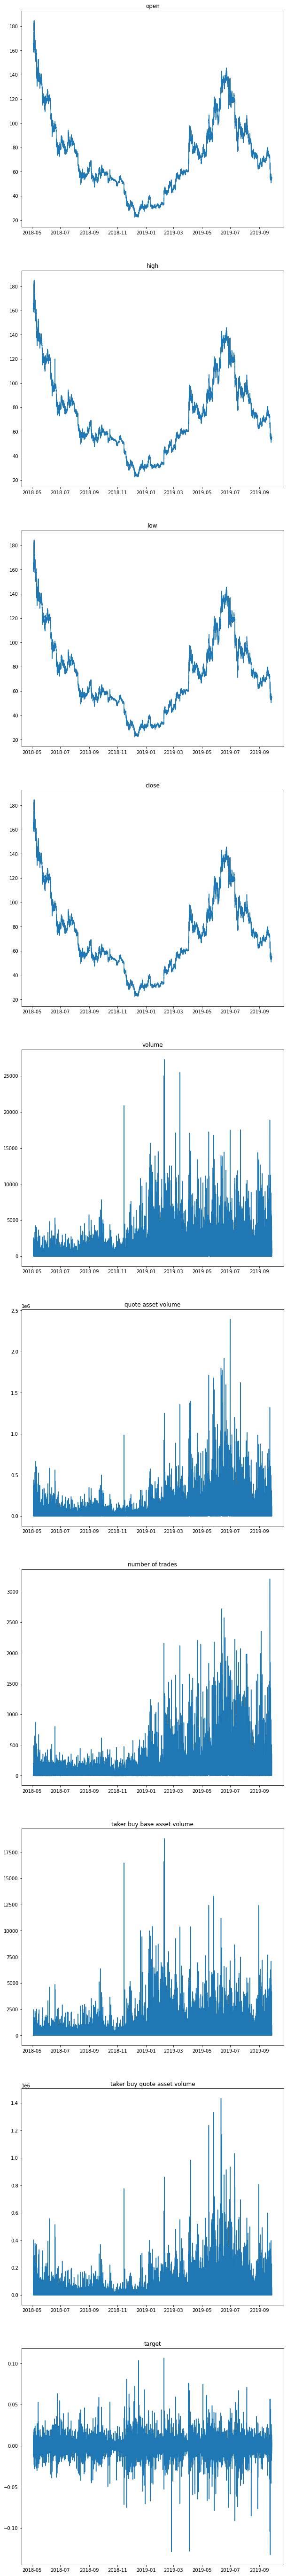

In [ ]:
if action == '3' or action == '4':
  fig = model.plot()
  # fig.tight_layout()
  fig.set_figheight(100)
  # fig.set_figwidth(100)

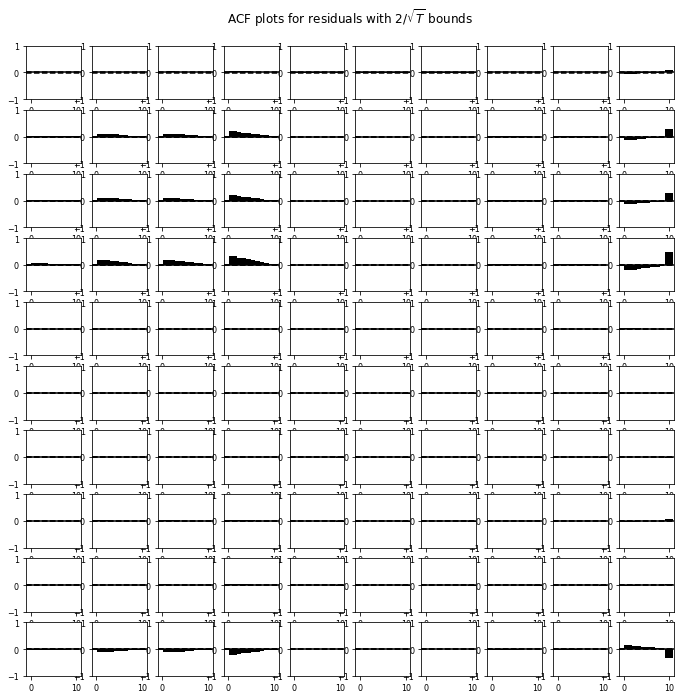

In [ ]:
if action == '3' or action == '4':
  model.plot_acorr()

In [ ]:
now = datetime.now()
E_timestamp = datetime.timestamp(now)
print("Start Time =", s_now)
print("End Time =", now)
Total = E_timestamp - S_timestamp
print("Total Time = " + str(Total/60) + " mins")

Start Time = 2021-05-02 01:45:22.715907
End Time = 2021-05-02 02:03:53.715603
Total Time = 18.51666160027186 mins


## XRPUSDT

In [ ]:
s_now = datetime.now()
S_timestamp = datetime.timestamp(s_now)
print("Start Time =", s_now)

Start Time = 2021-05-02 02:03:53.728227


#### Get Corresponding Data

In [ ]:
if action == '1' or action == '4':
  XRPUSDT_Training_Data = rawtrainingdata.loc[rawtrainingdata[crypto] == 'XRPUSDT']
if action == '3' or action == '4':
  XRPUSDT_Testing_Data = rawtestingdata.loc[rawtestingdata[crypto] == 'XRPUSDT']

In [ ]:
if action == '1' or action == '4':
  XRPUSDT_Training_Data

In [ ]:
if action == '3' or action == '4':
  XRPUSDT_Testing_Data

#### Data Preparation

In [ ]:
if action == '1' or action == '4':
  XRPUSDT_Training_Data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume', 'Quote asset volume': 'quote asset volume', 'Number of trades': 'number of trades', 'Taker buy base asset volume': 'taker buy base asset volume', 'Taker buy quote asset volume': 'taker buy quote asset volume'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
if action == '3' or action == '4':
  XRPUSDT_Testing_Data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume', 'Quote asset volume': 'quote asset volume', 'Number of trades': 'number of trades', 'Taker buy base asset volume': 'taker buy base asset volume', 'Taker buy quote asset volume': 'taker buy quote asset volume'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



- if datetime are duplicate, keep the last occurence
- add freq
- handle null values

In [ ]:
# if action == '1' or action == '4':
#   XRPUSDT_Training_Data, feature = dp1(XRPUSDT_Training_Data, feature)

In [ ]:
# if action == '3':
#   XRPUSDT_Testing_Data, feature = dp1(XRPUSDT_Testing_Data, feature)
# if action == '4':
#   XRPUSDT_Testing_Data, _ = dp1(XRPUSDT_Testing_Data, feature)

In [ ]:
# if action == '1' or action == '4':
#   XRPUSDT_Training_Data, feature = dp2(XRPUSDT_Training_Data, feature)

In [ ]:
# if action == '3':
#   XRPUSDT_Testing_Data, feature = dp2(XRPUSDT_Testing_Data, feature)
# if action == '4':
#   XRPUSDT_Testing_Data, _ = dp2(XRPUSDT_Testing_Data, feature)

In [ ]:
if action == '1' or action == '4':
  XRPUSDT_Training_Data = dp3(XRPUSDT_Training_Data, output)

DatetimeIndex(['2018-05-04 08:12:00+00:00', '2018-05-04 08:13:00+00:00',
               '2018-05-04 08:14:00+00:00', '2018-05-04 08:15:00+00:00',
               '2018-05-04 08:16:00+00:00', '2018-05-04 08:17:00+00:00',
               '2018-05-04 08:18:00+00:00', '2018-05-04 08:19:00+00:00',
               '2018-05-04 08:20:00+00:00', '2018-05-04 08:21:00+00:00',
               ...
               '2020-09-02 21:00:00+00:00', '2020-09-02 21:01:00+00:00',
               '2020-09-02 21:02:00+00:00', '2020-09-02 21:03:00+00:00',
               '2020-09-02 21:04:00+00:00', '2020-09-02 21:05:00+00:00',
               '2020-09-02 21:06:00+00:00', '2020-09-02 21:07:00+00:00',
               '2020-09-02 21:08:00+00:00', '2020-09-02 21:09:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=1223217, freq=None)
Index(['id', 'name', 'open', 'high', 'low', 'close', 'volume',
       'quote asset volume', 'number of trades', 'taker buy base asset volume',
       'taker buy quote 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



- SMA 10
- RSI 14
- MACD 12

In [ ]:
# if action == '1' or action == '4':
#   XRPUSDT_Training_Data, _ = dp4(XRPUSDT_Training_Data, feature)

In [ ]:
# if action == '3' or action == '4':
#   XRPUSDT_Testing_Data, _ = dp4(XRPUSDT_Testing_Data, feature)

In [ ]:
# if action == '1' or action == '4':
#   XRPUSDT_Training_Data, _ = dp5(XRPUSDT_Training_Data, feature)

In [ ]:
# if action == '3' or action == '4':
#   XRPUSDT_Testing_Data, _ = dp5(XRPUSDT_Testing_Data, feature)

In [ ]:
# if action == '1' or action == '4':
#   XRPUSDT_Training_Data, _ = dp6(XRPUSDT_Training_Data, feature)

In [ ]:
# if action == '3' or action == '4':
#   XRPUSDT_Testing_Data, _ = dp6(XRPUSDT_Testing_Data, feature)

In [ ]:
# if action == '1' or action == '4':
#   del XRPUSDT_Training_Data['open']
#   del XRPUSDT_Training_Data['high']
#   del XRPUSDT_Training_Data['low']
#   del XRPUSDT_Training_Data['close']

In [ ]:
# if action == '3' or action == '4':
#   del XRPUSDT_Testing_Data['open']
#   del XRPUSDT_Testing_Data['high']
#   del XRPUSDT_Testing_Data['low']
#   del XRPUSDT_Testing_Data['close']

#### Data Visualization

In [ ]:
if action == '1' or action == '4':
  XRPUSDT_Training_Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1227658 entries, 2018-05-04 08:12:00+00:00 to 2020-09-02 21:09:00+00:00
Freq: T
Data columns (total 12 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   id                            1227658 non-null  float64
 1   name                          1227658 non-null  object 
 2   open                          1227658 non-null  float64
 3   high                          1227658 non-null  float64
 4   low                           1227658 non-null  float64
 5   close                         1227658 non-null  float64
 6   volume                        1227658 non-null  float64
 7   quote asset volume            1227658 non-null  float64
 8   number of trades              1227658 non-null  float64
 9   taker buy base asset volume   1227658 non-null  float64
 10  taker buy quote asset volume  1227658 non-null  float64
 11  target                        122765

In [ ]:
if action == '1' or action == '4':
  XRPUSDT_Training_Data.describe()

In [ ]:
if action == '3' or action == '4':
  XRPUSDT_Testing_Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215653 entries, 2020-09-02 21:10:00+00:00 to 2021-01-30 21:10:00+00:00
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            215653 non-null  int64  
 1   name                          215653 non-null  object 
 2   open                          215653 non-null  float64
 3   high                          215653 non-null  float64
 4   low                           215653 non-null  float64
 5   close                         215653 non-null  float64
 6   volume                        215653 non-null  float64
 7   quote asset volume            215653 non-null  float64
 8   number of trades              215653 non-null  int64  
 9   taker buy base asset volume   215653 non-null  float64
 10  taker buy quote asset volume  215653 non-null  float64
dtypes: float64(8), int64(2), object(1)
memory usage: 19.7+ MB


In [ ]:
if action == '3' or action == '4':
  XRPUSDT_Testing_Data.describe()

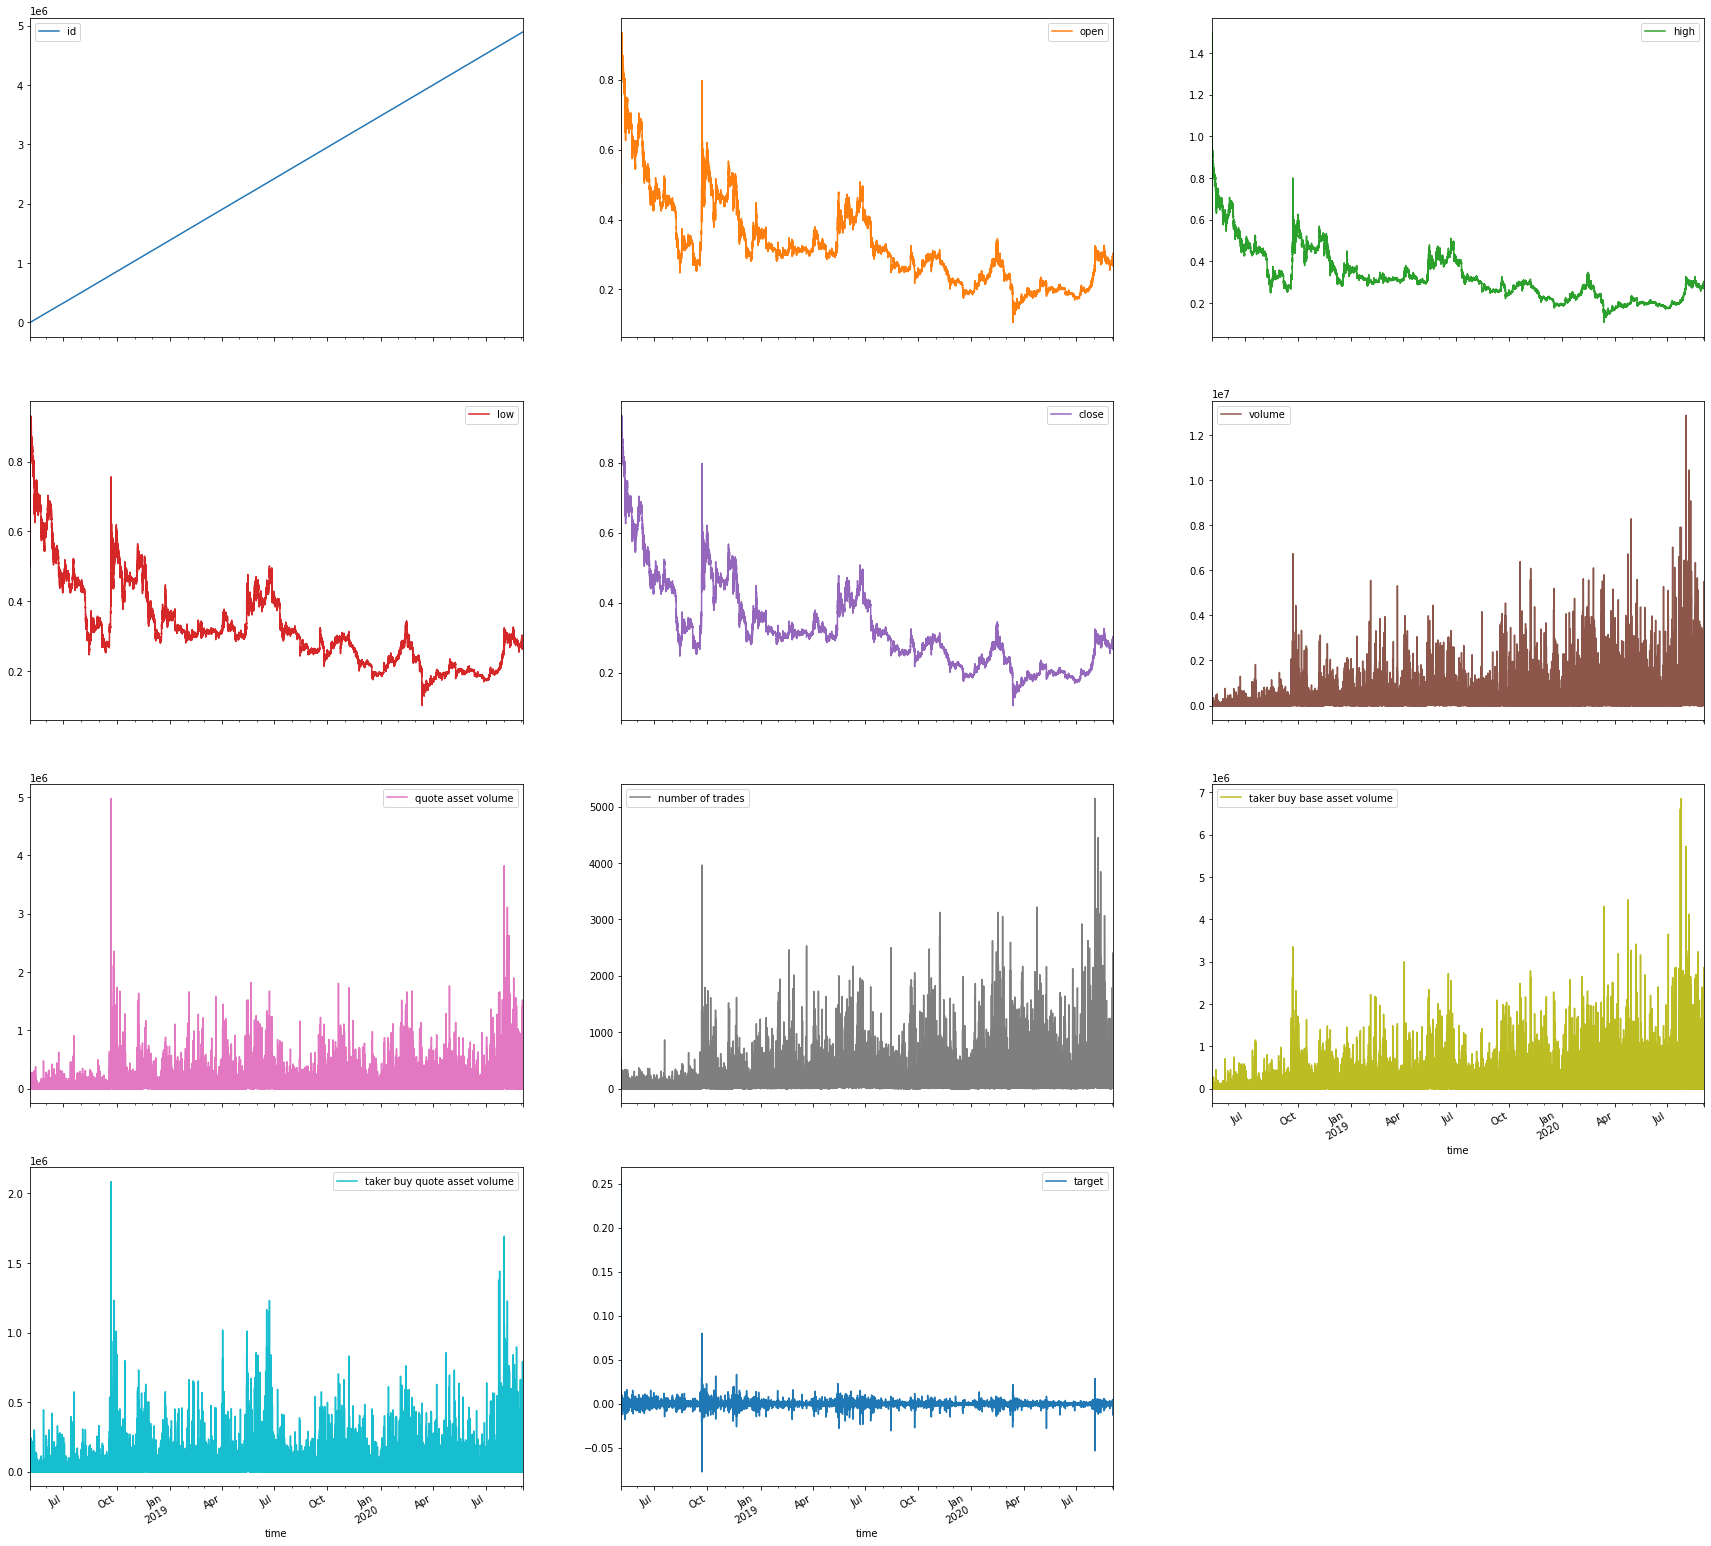

In [ ]:
if action == '1' or action == '4':
  dv(XRPUSDT_Training_Data)

                                  open      high       low     close  \
open                          1.000000  0.999984  0.999992  0.999991   
high                          0.999984  1.000000  0.999976  0.999985   
low                           0.999992  0.999976  1.000000  0.999993   
close                         0.999991  0.999985  0.999993  1.000000   
volume                       -0.092652 -0.091484 -0.094190 -0.092847   
quote asset volume            0.052803  0.054185  0.050981  0.052589   
number of trades             -0.070214 -0.068886 -0.071928 -0.070414   
taker buy base asset volume  -0.080594 -0.079201 -0.081676 -0.080237   
taker buy quote asset volume  0.058947  0.060585  0.057671  0.059389   
target                       -0.011879 -0.011948 -0.011904 -0.012030   

                                volume  quote asset volume  number of trades  \
open                         -0.092652            0.052803         -0.070214   
high                         -0.091484         

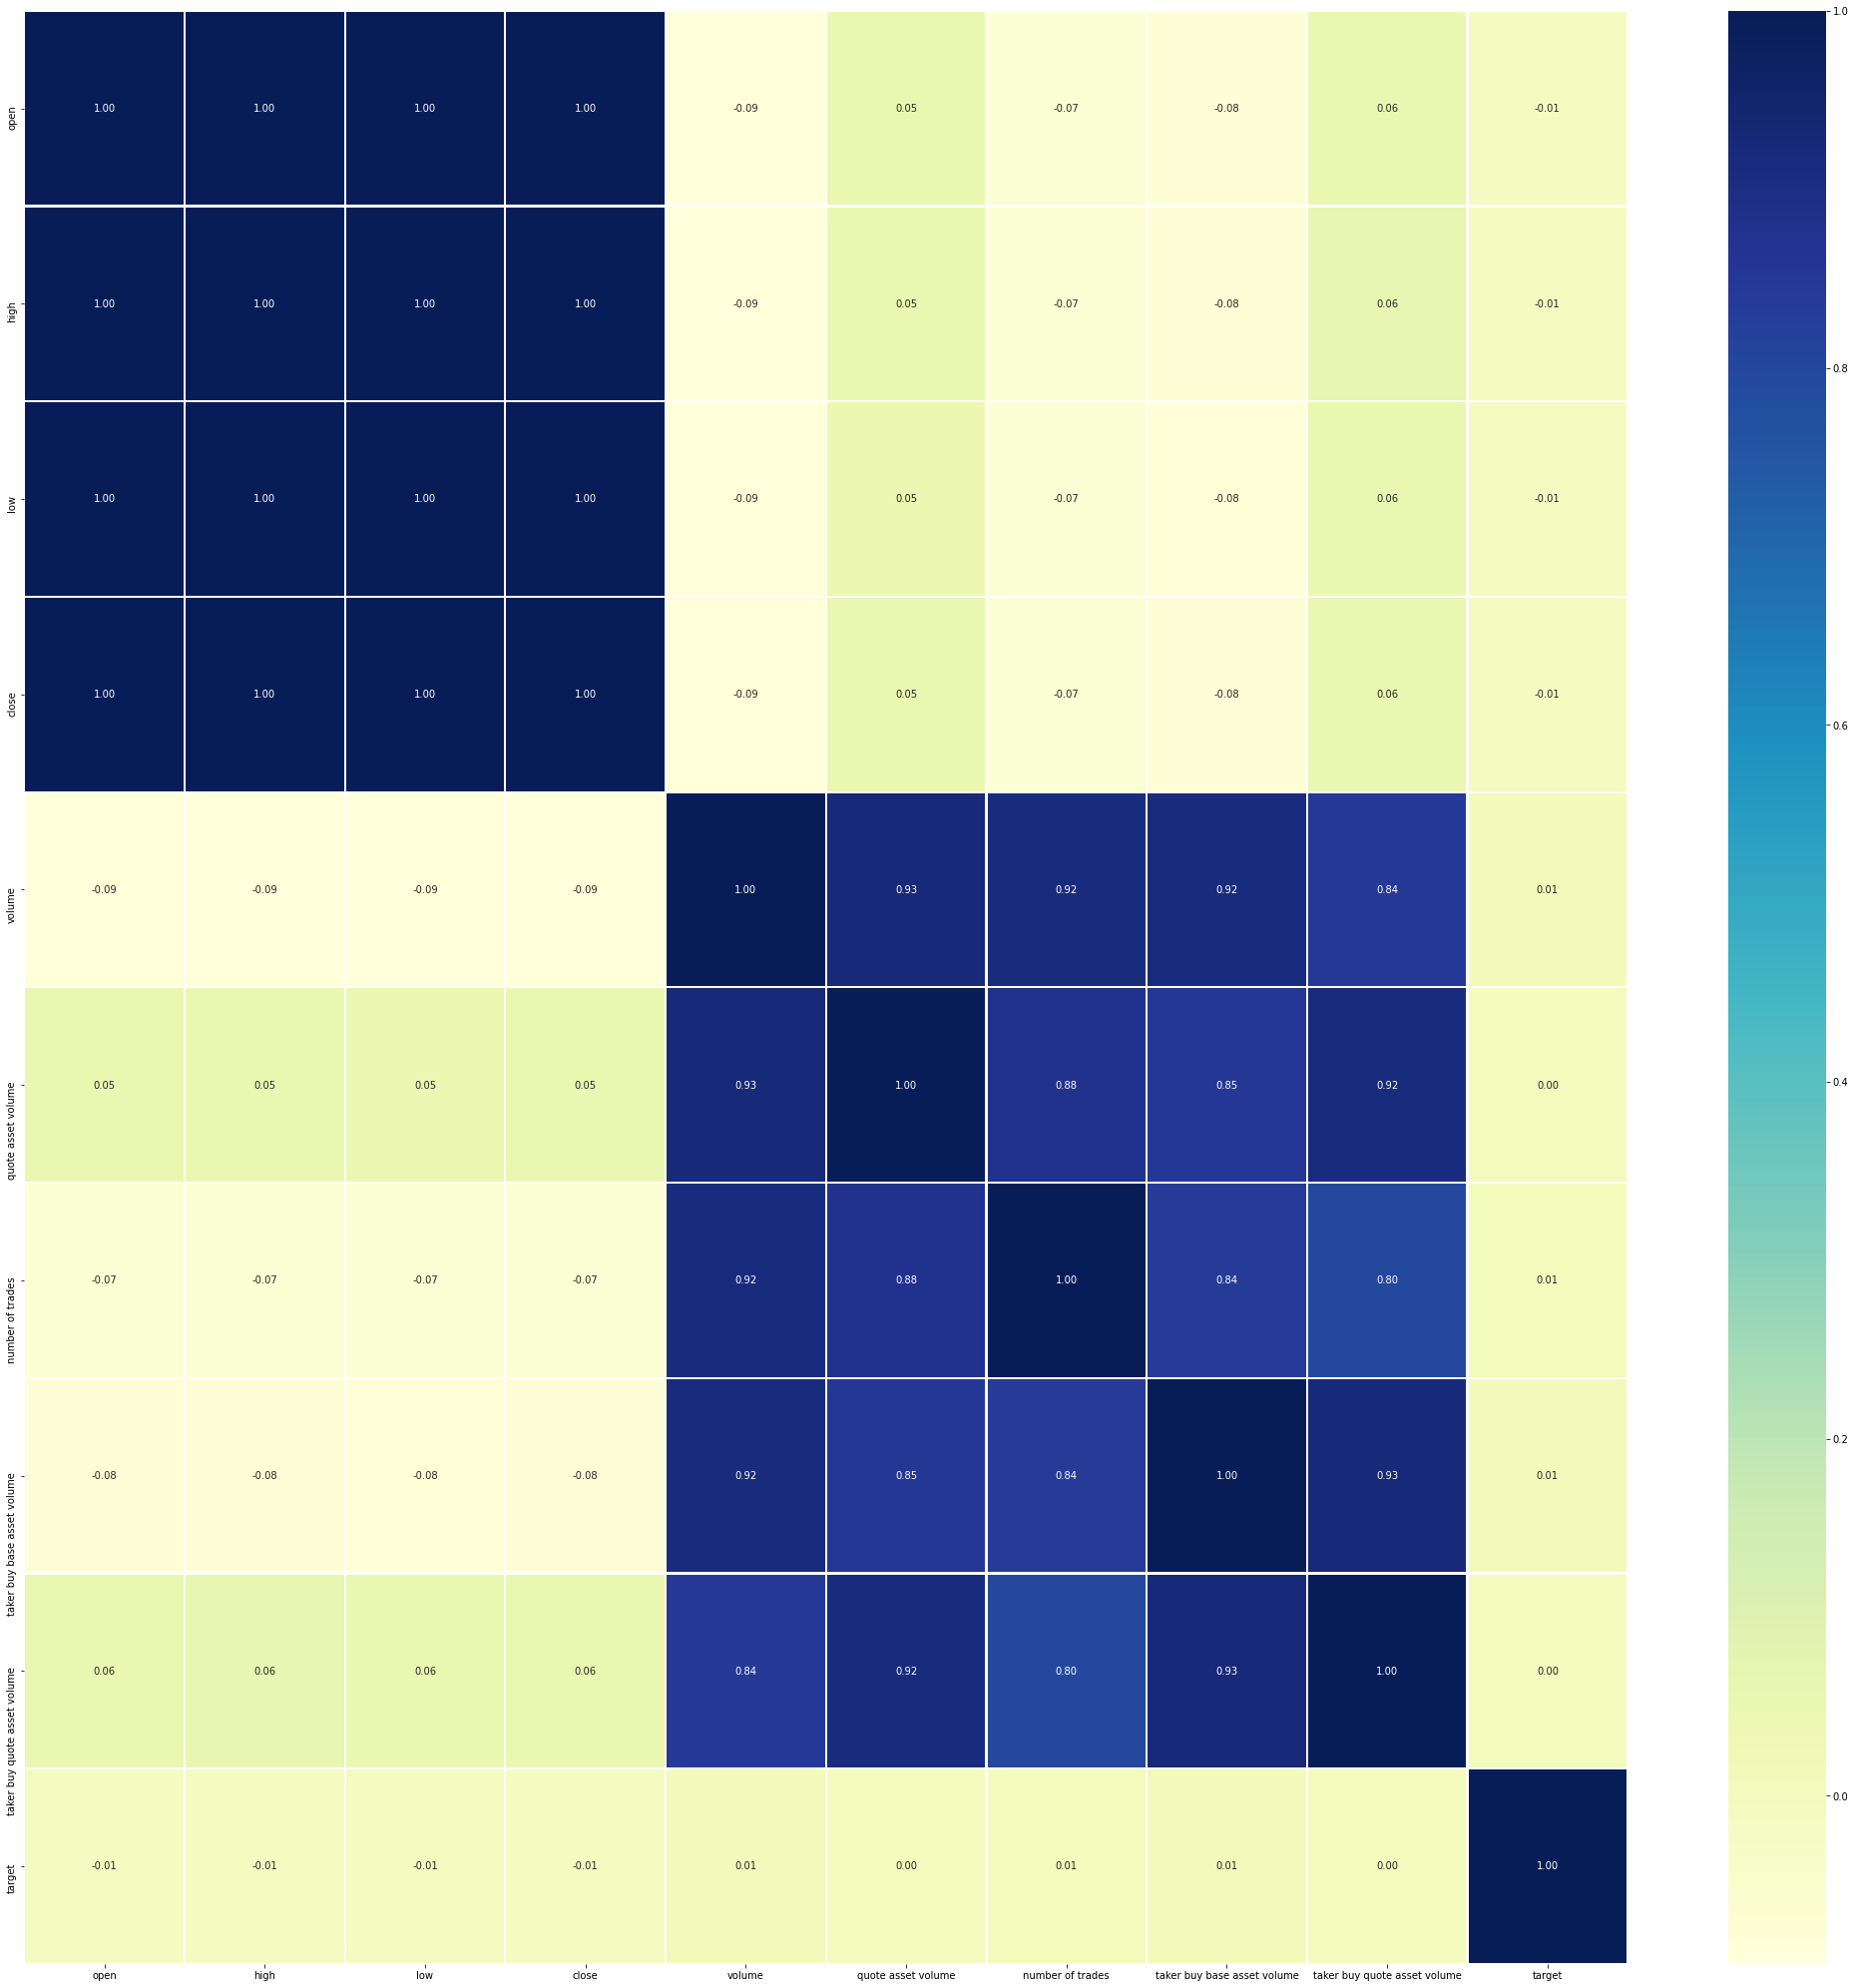

In [ ]:
if action == '1' or action == '4':
  corr(XRPUSDT_Training_Data, 'XRPUSDT')

In [ ]:
if action == '1':
  XRPUSDT_Training_Data.to_csv(folder + "XRPUSDT_Training_Data.csv", index=True)

In [ ]:
# if action == '3':
#   XRPUSDT_Testing_Data.to_csv(folder + "XRPUSDT_Testing_Data.csv", index=True)

In [ ]:
if action == '2':
  XRPUSDT_Training_Data = readCsvData(folder + "XRPUSDT_Training_Data.csv", 0)

In [ ]:
# if action == '3':
#   XRPUSDT_Testing_Data = readCsvData(folder + "XRPUSDT_Testing_Data.csv", 0)

#### Multivariate Time Series

In [ ]:
# lag = 1
# mtsModel = mts(id, crypto, feature, output, XRPUSDT_Training_Data, 1)
# autolag
if action == '2' or action == '4':
  mtsModel = mts(id, crypto, feature, output, XRPUSDT_Training_Data, "auto")
  saveModel(mtsModel, folder + "XRPUSDTmtsModel.pkl")

                              open     high      low    close     volume  \
time                                                                       
2018-05-04 08:12:00+00:00  0.50000  0.50000  0.50000  0.50000     109.51   
2018-05-04 08:13:00+00:00  0.90000  0.92999  0.85000  0.90000  167543.47   
2018-05-04 08:14:00+00:00  0.90000  0.93000  0.89001  0.91000  179750.59   
2018-05-04 08:15:00+00:00  0.91000  1.50000  0.90009  0.92999  107222.48   
2018-05-04 08:16:00+00:00  0.92999  0.95001  0.91020  0.91020  171304.56   
...                            ...      ...      ...      ...        ...   
2020-09-02 21:05:00+00:00  0.27542  0.27558  0.27540  0.27558  132690.10   
2020-09-02 21:06:00+00:00  0.27558  0.27560  0.27552  0.27560   19277.90   
2020-09-02 21:07:00+00:00  0.27557  0.27578  0.27557  0.27575   83146.00   
2020-09-02 21:08:00+00:00  0.27575  0.27584  0.27575  0.27580   66498.00   
2020-09-02 21:09:00+00:00  0.27580  0.27580  0.27573  0.27576   33041.10   

           

/usr/local/lib/python3.7/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning:

y is a deprecated alias for endog, will be removed in version 0.11.0



model_fit.y
[[5.00000000e-01 5.00000000e-01 5.00000000e-01 ... 0.00000000e+00
  0.00000000e+00 2.52572895e-01]
 [9.00000000e-01 9.29990000e-01 8.50000000e-01 ... 1.29949270e+05
  1.16854604e+05 1.24952919e-02]
 [9.00000000e-01 9.30000000e-01 8.90010000e-01 ... 1.09352280e+05
  9.93994298e+04 6.28074971e-04]
 ...
 [2.40500000e-01 2.40660000e-01 2.40490000e-01 ... 1.87370000e+03
  4.50871866e+02 1.03117708e-03]
 [2.40580000e-01 2.40610000e-01 2.40350000e-01 ... 3.19892000e+04
  7.69640797e+03 1.19246185e-03]
 [2.40390000e-01 2.40540000e-01 2.40320000e-01 ... 3.99080000e+03
  9.59663955e+02 1.12005104e-03]]
train.values[-lag_order:]
[[ 2.41110000e-01  2.41110000e-01  2.40670000e-01  2.40750000e-01
   2.09913000e+04  5.05927489e+03  2.10000000e+01  2.93960000e+03
   7.08091531e+02 -3.30499904e-04]
 [ 2.40560000e-01  2.40660000e-01  2.40490000e-01  2.40560000e-01
   3.37118000e+04  8.11083734e+03  4.40000000e+01  2.11646000e+04
   5.09165945e+03  8.06084324e-06]
 [ 2.40560000e-01  2.4056000

## XRPUSDT Prediction Model

#### Multivariate Time Series Predict

In [ ]:
if action == '3':
  model = loadModel(folder + "XRPUSDTmtsModel.pkl")
  pred = mtsPredict(id, crypto, output, XRPUSDT_Testing_Data, model)
if action == '4':
  model = mtsModel
  pred = mtsPredict(id, crypto, output, XRPUSDT_Testing_Data, model)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning:

y is a deprecated alias for endog, will be removed in version 0.11.0



In [ ]:
if action == '3' or action == '4':
  XRPUSDT_Testing_Data_no_tz = XRPUSDT_Testing_Data.reset_index()[["id"]].copy()
  XRPUSDT_submission = pd.concat( [XRPUSDT_Testing_Data_no_tz, pred], axis=1 )

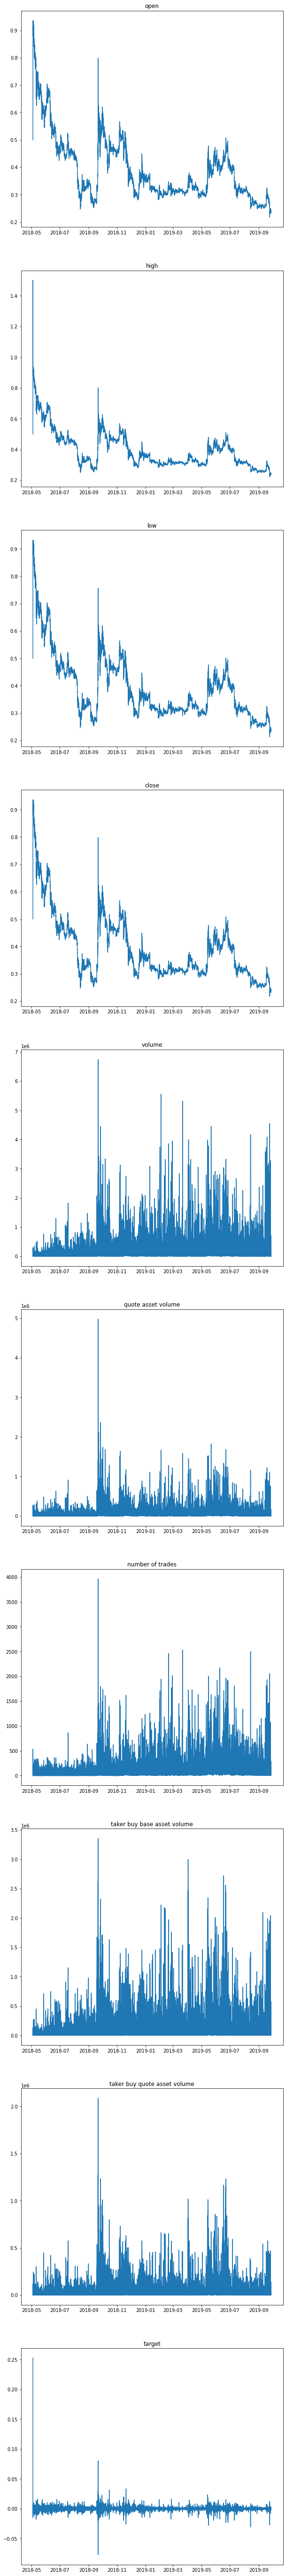

In [ ]:
if action == '3' or action == '4':
  fig = model.plot()
  # fig.tight_layout()
  fig.set_figheight(100)
  # fig.set_figwidth(100)

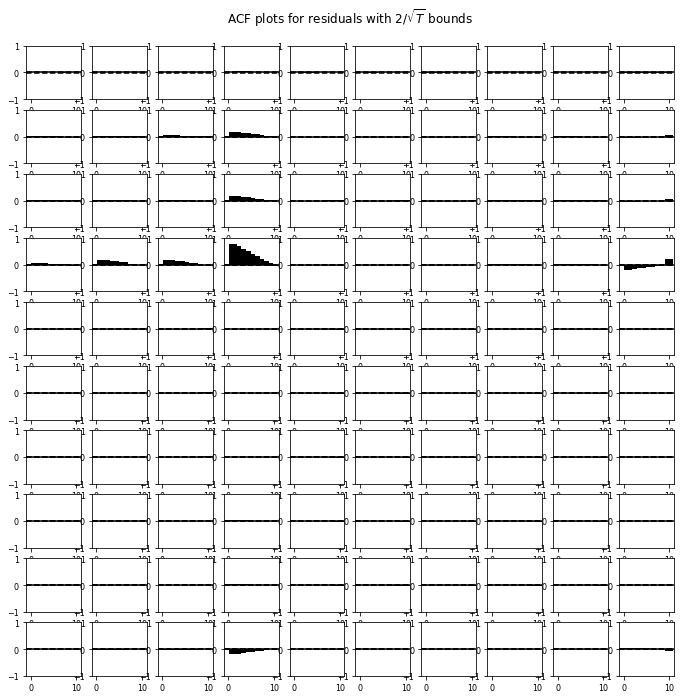

In [ ]:
if action == '3' or action == '4':
  model.plot_acorr()

In [ ]:
now = datetime.now()
E_timestamp = datetime.timestamp(now)
print("Start Time =", s_now)
print("End Time =", now)
Total = E_timestamp - S_timestamp
print("Total Time = " + str(Total/60) + " mins")

Start Time = 2021-05-02 02:03:53.728227
End Time = 2021-05-02 02:22:23.326600
Total Time = 18.49330621957779 mins


## Combine Results

In [ ]:
if action == '3' or action == '4':
  submission = pd.concat( [BTCUSDT_submission, ETHUSDT_submission, LTCUSDT_submission, XRPUSDT_submission], axis=0 )

In [ ]:
if action == '3' or action == '4':
  submission.sort_values(by=['id'])

In [ ]:
if action == '3' or action == '4':
  submission = submission.rename(columns={"id": "id", "target": "Predicted"})

In [ ]:
if action == '3' or action == '4':
  submission.to_csv(folder + "Submission.csv", index=False)

In [ ]:
now = datetime.now()
E_timestamp = datetime.timestamp(now)
print("Start Time =", ps_now)
print("End Time =", now)
Total = E_timestamp - PS_timestamp
print("Total Time = " + str(Total/60) + " mins")

Start Time = 2021-05-02 01:07:49.411114
End Time = 2021-05-02 02:22:26.060238
Total Time = 74.61081873178482 mins
